# このnotebookについて

# 事前準備

In [111]:
import os
import json

import numpy as np
import pandas as pd
import pwlf
import h5py

In [112]:
# 自作モジュールの読み込み
from modules.file_format.HDF5 import HDF5Reader, HDF5Writer


In [113]:
"""pathの設定"""
import sys
repository_root = None
for sys_path in sys.path:
    if sys_path.endswith('LAMBDA-Melting'):
        repository_root = sys_path
if repository_root is None:
    raise ValueError('repository_root is not set')

"""plot用の設定"""
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['mathtext.fontset'] = 'cm'     #数式用のフォントejavuserif" or "cm"
plt.rcParams['xtick.direction'] = 'in'      #x軸の目盛線 #内in')か外向き('out')か双方向か('inout')
plt.rcParams['ytick.direction'] = 'in'      #y軸の目盛線 #内in')か外向き('out')か双方向か('inout')
plt.rcParams['xtick.major.width'] = 1.0     #x軸主目盛り線の線幅
plt.rcParams['ytick.major.width'] = 1.0     #y軸主目盛り線の線幅
plt.rcParams['font.size'] = 14               #フォントの大きさ
plt.rcParams['axes.linewidth'] = 0.8        #軸の線幅edge linewidth。囲みの太さ
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = (8, 6)
# Arialフォントを設定
plt.rcParams.update({
    "font.family": "Arial",           # フォントをArialに設定
    "mathtext.fontset": "custom",     # カスタムフォントを指定
    "mathtext.rm": "Arial",           # 数式の通常テキスト部分
    "mathtext.it": "Arial",    # 数式のイタリック部分
    "mathtext.bf": "Arial"       # 数式の太字部分
})

# 読み込み先の設定

## 選んだRunを読み込み

In [114]:
# runの読み込み
# Run Selectorで選択したことを想定する
path_to_run_setting = os.path.join(repository_root, 'settings', 'run_selector.json')
with open(path_to_run_setting) as json_file:
    selected_run_setting = json.load(json_file)

In [115]:
selected_run_setting

{'data_root_path': '/Users/ishizawaosamu/work/MasterThesis/data',
 'current_run': 'OIbDia08_7th',
 'path_to_run_files': '/Users/ishizawaosamu/work/MasterThesis/data/BDD/OIbDia08/7th',
 'selected_files': {'Temperature': {'raw_radiation': 'OIbDia08_ 09.spe',
   'dist': 'OIbDia08_ 09_separate_half_p30e-2_dist.hdf'},
  'XRD': {'data': 'OIbDia08_9_00000.nxs',
   'calibration': 'pyFAI_calib2_MgS400_CeO2_240511.poni'}},
 'is_overwritten': True,
 'save_root_path': '/Users/ishizawaosamu/work/MasterThesis/save'}

## 測定温度が入ったhdfを読み込み

In [116]:
# up
up_hdf = HDF5Reader(file_path=os.path.join(
    selected_run_setting['save_root_path'],
    'processed_hdf',
    f'{selected_run_setting["current_run"]}_up_processed.hdf'
))

# down
down_hdf = HDF5Reader(file_path=os.path.join(
    selected_run_setting['save_root_path'],
    'processed_hdf',
    f'{selected_run_setting["current_run"]}_down_processed.hdf'
))

up_hdf.path_list

HDF5ファイルが見つかりました: /Users/ishizawaosamu/work/MasterThesis/save/processed_hdf/OIbDia08_7th_up_processed.hdf
HDF5ファイルが見つかりました: /Users/ishizawaosamu/work/MasterThesis/save/processed_hdf/OIbDia08_7th_down_processed.hdf


['entry/measured/error/T',
 'entry/measured/value/T',
 'entry/measured/value/frame_T',
 'entry/measured/value/max_position_T',
 'entry/params/frame/T',
 'entry/params/framerate/T']

In [117]:
# データを取得
# streamに依存するもの
up_T_array = up_hdf.find_by(query='measured/value/T')
down_T_array = down_hdf.find_by(query='measured/value/T')

# streamに依存しないもの
frame_array = down_hdf.find_by(query='measured/value/frame_T')
framerate = down_hdf.find_by(query='framerate')
frame_num = down_hdf.find_by(query='/frame/T')

「measured/value/T」で検索します。
	-> entry/measured/value/T を返しました。
「measured/value/T」で検索します。
	-> entry/measured/value/T を返しました。
「measured/value/frame_T」で検索します。
	-> entry/measured/value/frame_T を返しました。
「framerate」で検索します。
	-> entry/params/framerate/T を返しました。
「/frame/T」で検索します。
	-> entry/params/frame/T を返しました。


In [118]:
# 必要な配列を作成
time_array = frame_array / framerate

In [119]:
# pd.Seriesの作成と条件に基づくフィルタリング
def get_filtered_series(T_arr, time_arr, min_threshold=1_000):
    T_seri = pd.Series(data=T_arr, index=time_arr).dropna()
    T_seri = T_seri[T_seri >= min_threshold]
    return T_seri

up_T_series = get_filtered_series(up_T_array, time_array)
down_T_series = get_filtered_series(down_T_array, time_array)

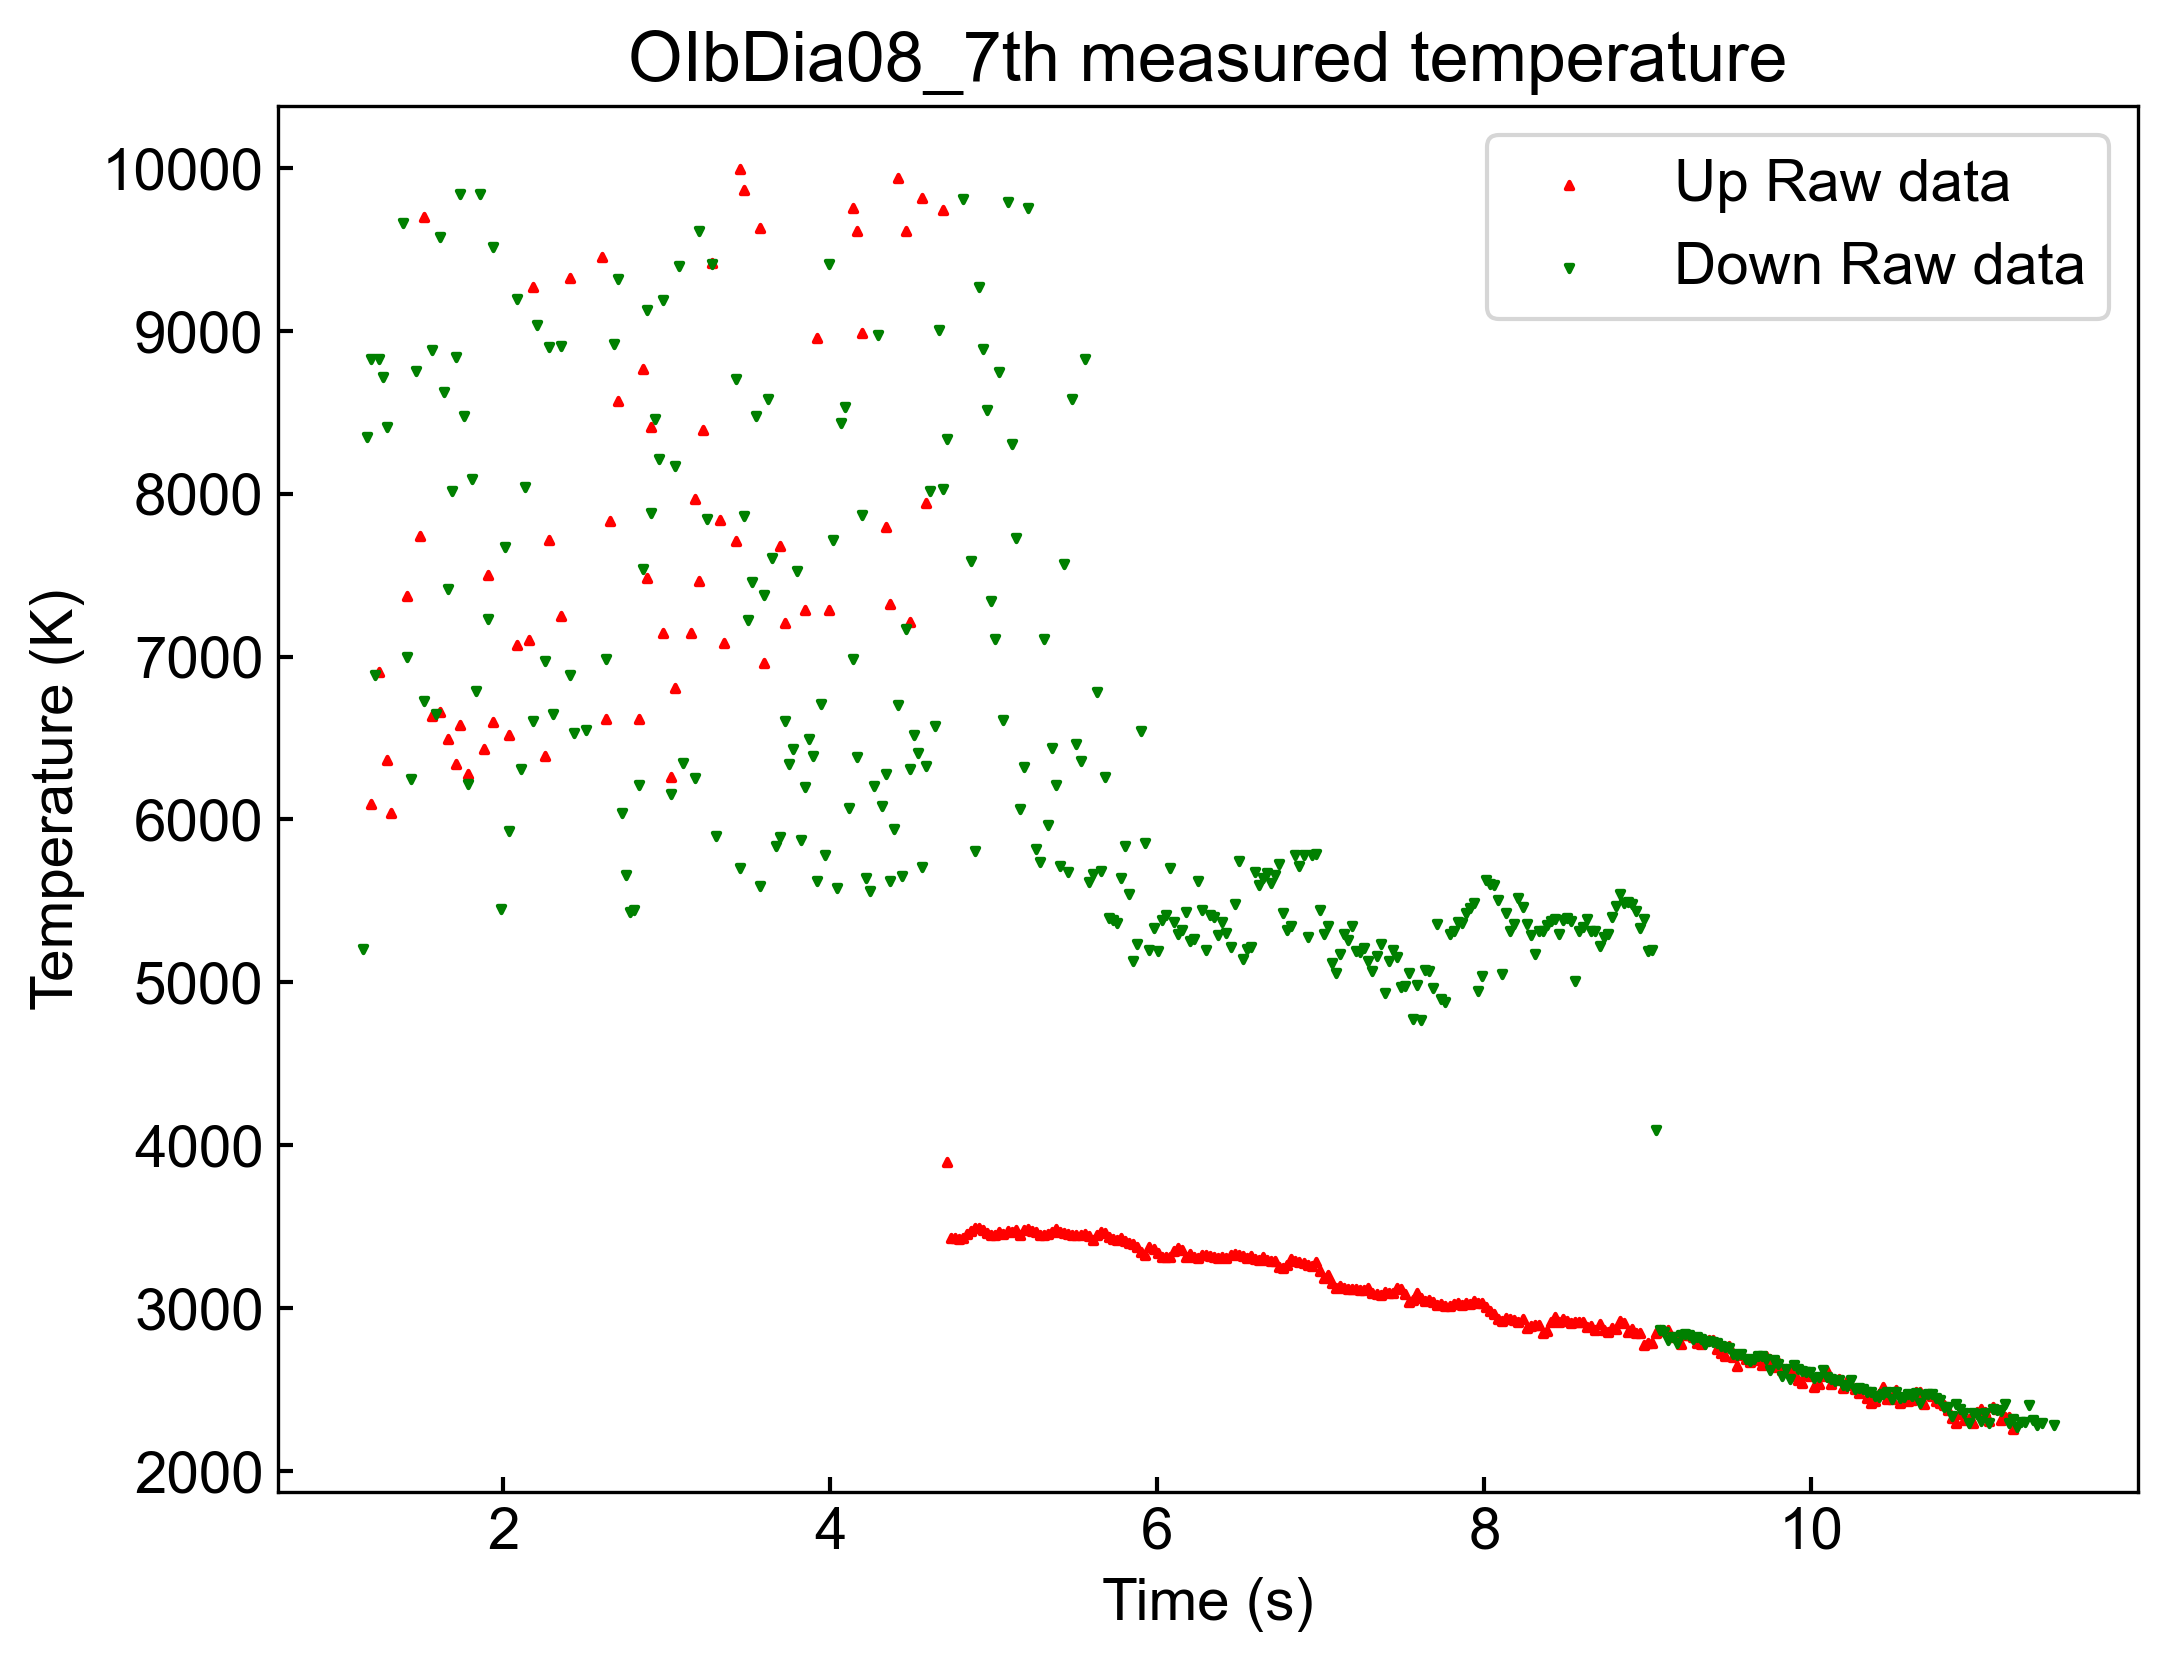

In [120]:
# 図示して確認
plt.scatter(up_T_series.index, up_T_series.values, label='Up Raw data', s=3, color='red', marker='^')
plt.scatter(down_T_series.index, down_T_series.values, label='Down Raw data', s=3, color='green', marker='v')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Temperature (K)')
plt.title(f'{selected_run_setting["current_run"]} measured temperature')
plt.savefig(os.path.join(selected_run_setting['save_root_path'], 'fig', 'measured_T_for_pwlf', selected_run_setting['current_run']+'.png'))
plt.show()
plt.close()


# 区分線形fitting

In [121]:
segments_num_list = [2, 3, 4, 5]

## Up

In [122]:
up_pwlf = pwlf.PiecewiseLinFit(up_T_series.index, up_T_series.values)

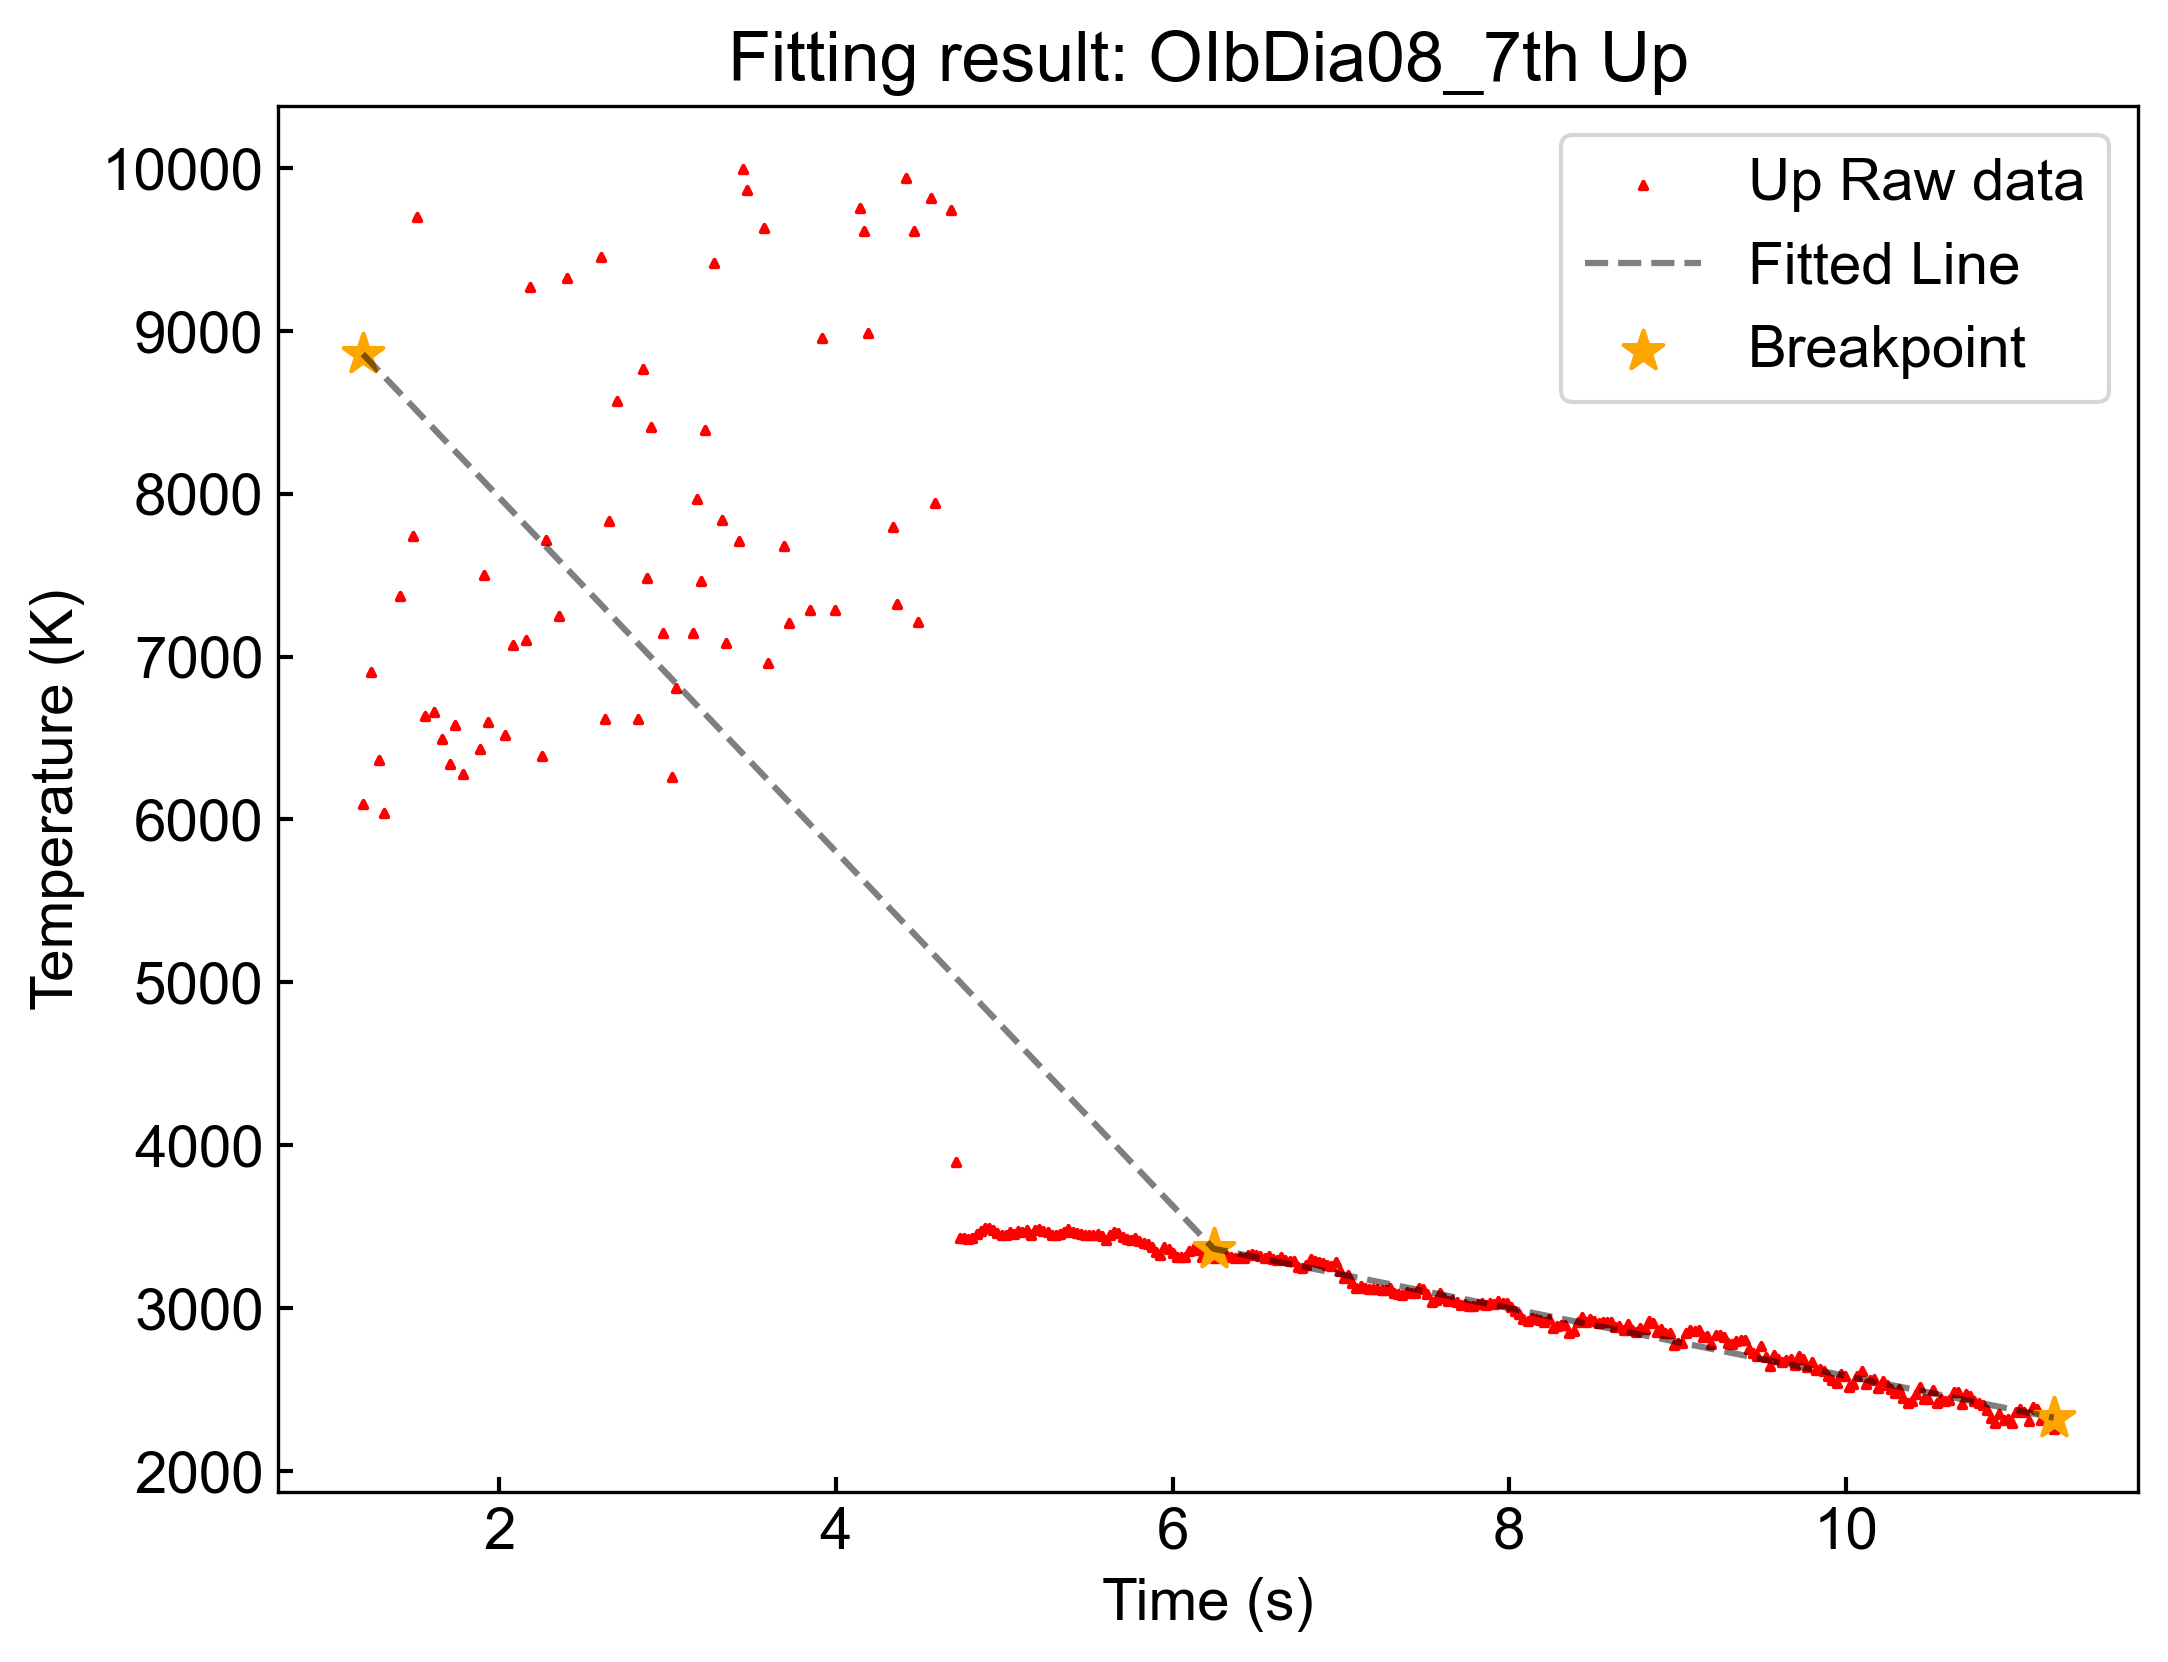

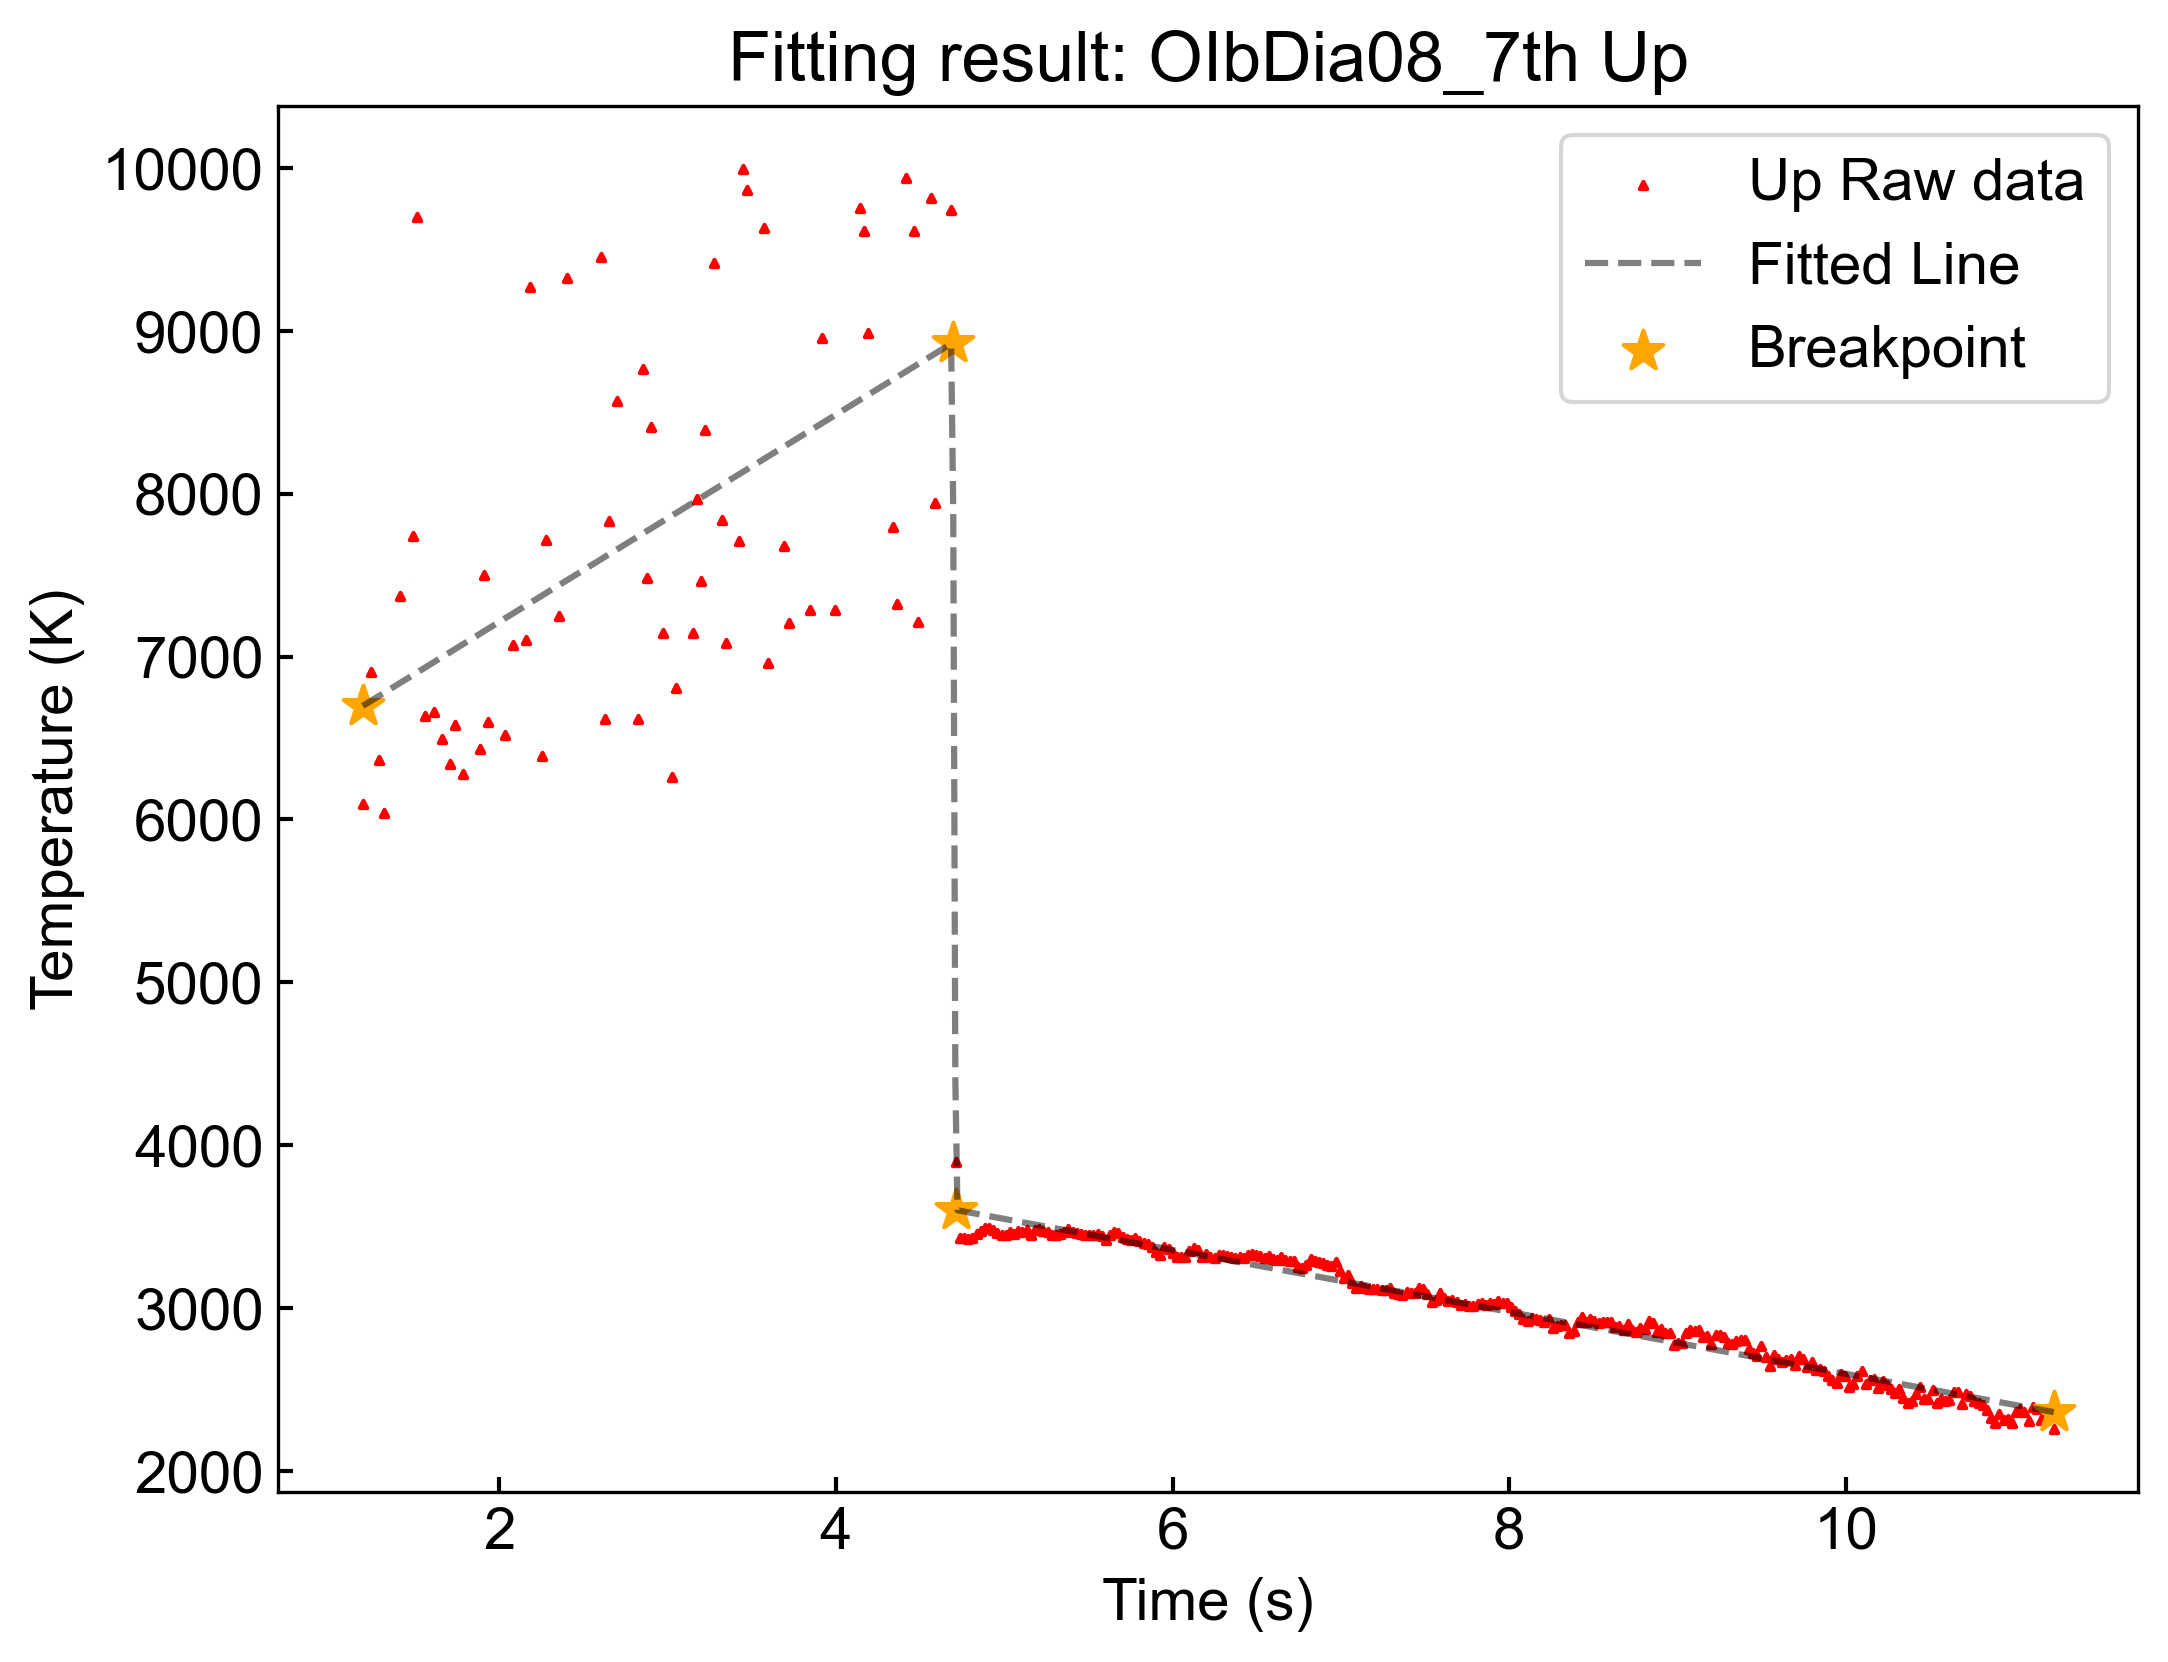

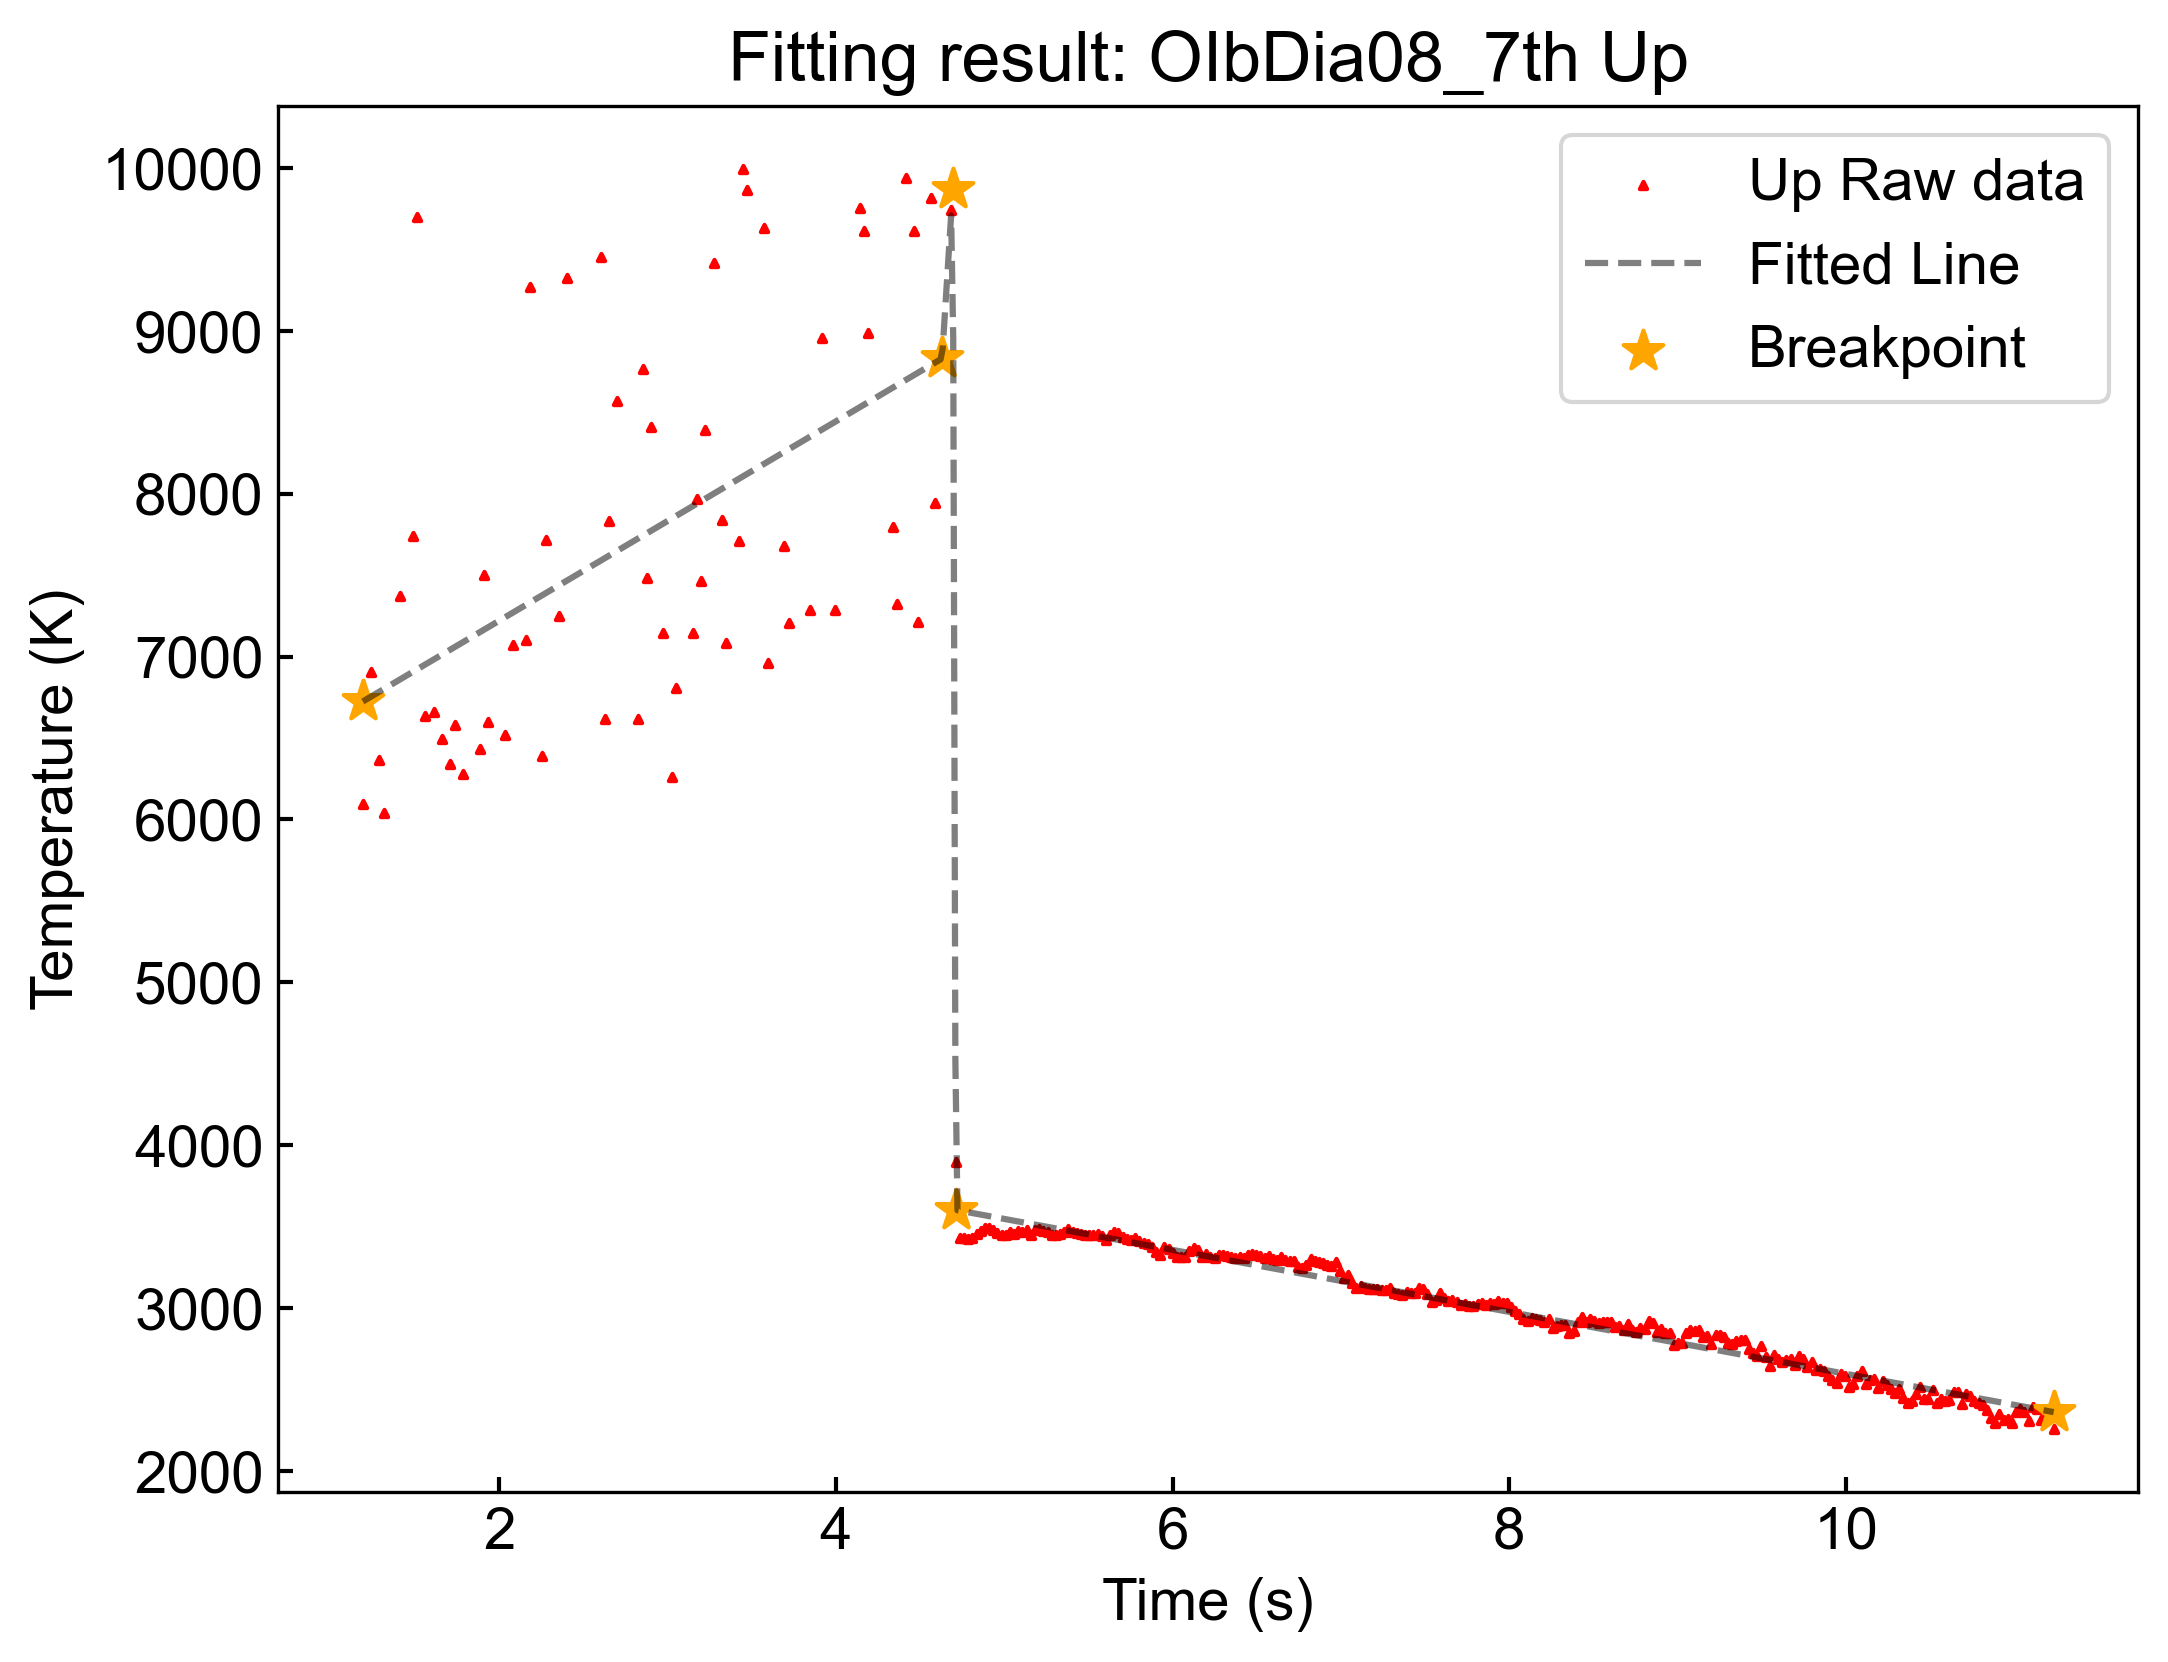

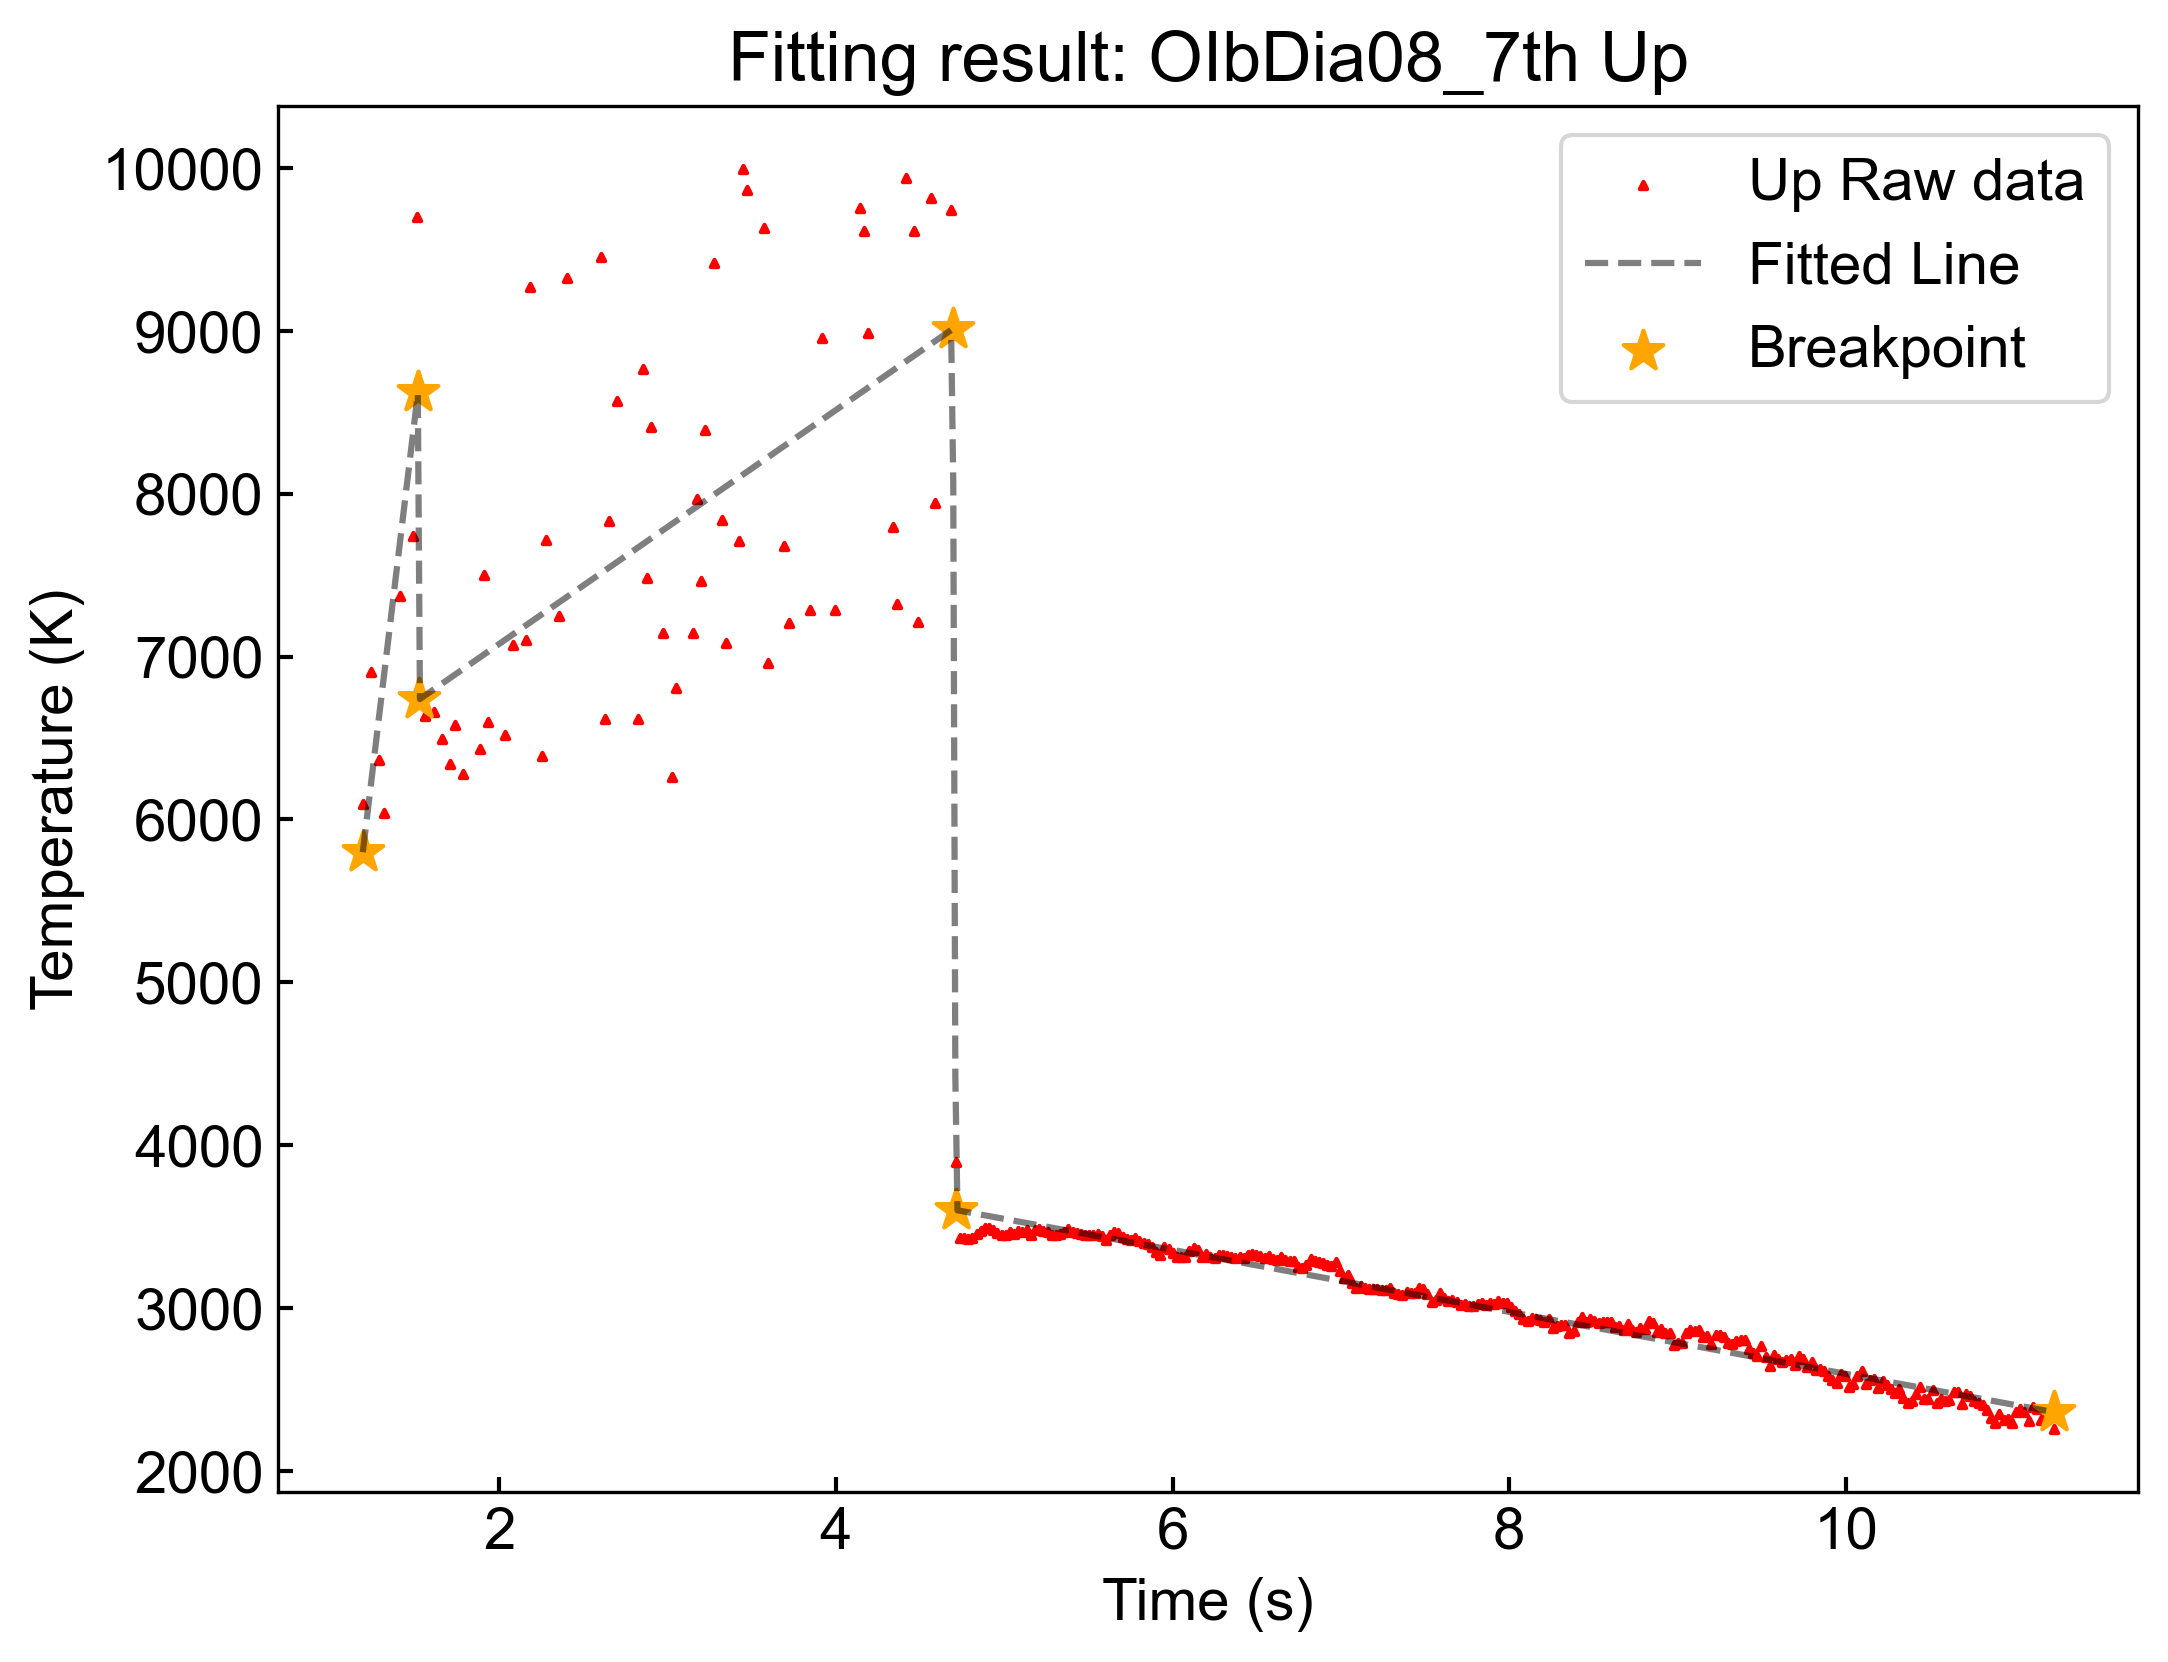

In [123]:
for up_segment_num in segments_num_list:
    res = up_pwlf.fit(up_segment_num)

    # 図示用配列
    up_x_hat_all = np.linspace(up_T_series.index.min(), up_T_series.index.max(), frame_num)
    up_y_hat_all = up_pwlf.predict(up_x_hat_all)

    # 図示
    plt.scatter(up_T_series.index, up_T_series.values, label='Up Raw data', s=3, color='red', marker='^')
    plt.plot(up_x_hat_all, up_y_hat_all, color='black', label='Fitted Line', alpha=0.5, linestyle='--')
    plt.scatter(up_pwlf.fit_breaks, up_pwlf.predict(up_pwlf.fit_breaks), label='Breakpoint', s=100, marker='*', color='orange')
    plt.xlabel('Time (s)')
    plt.legend()
    plt.xlabel('Time (s)')
    plt.ylabel('Temperature (K)')
    plt.title(f'Fitting result: {selected_run_setting["current_run"]} Up')
    plt.savefig(os.path.join(selected_run_setting['save_root_path'], 'fig', 'pwlf_fitting', selected_run_setting['current_run']+f'_up_{up_segment_num}.png'))
    plt.show()
    plt.close()


## Down

In [124]:
down_pwlf = pwlf.PiecewiseLinFit(down_T_series.index, down_T_series.values)

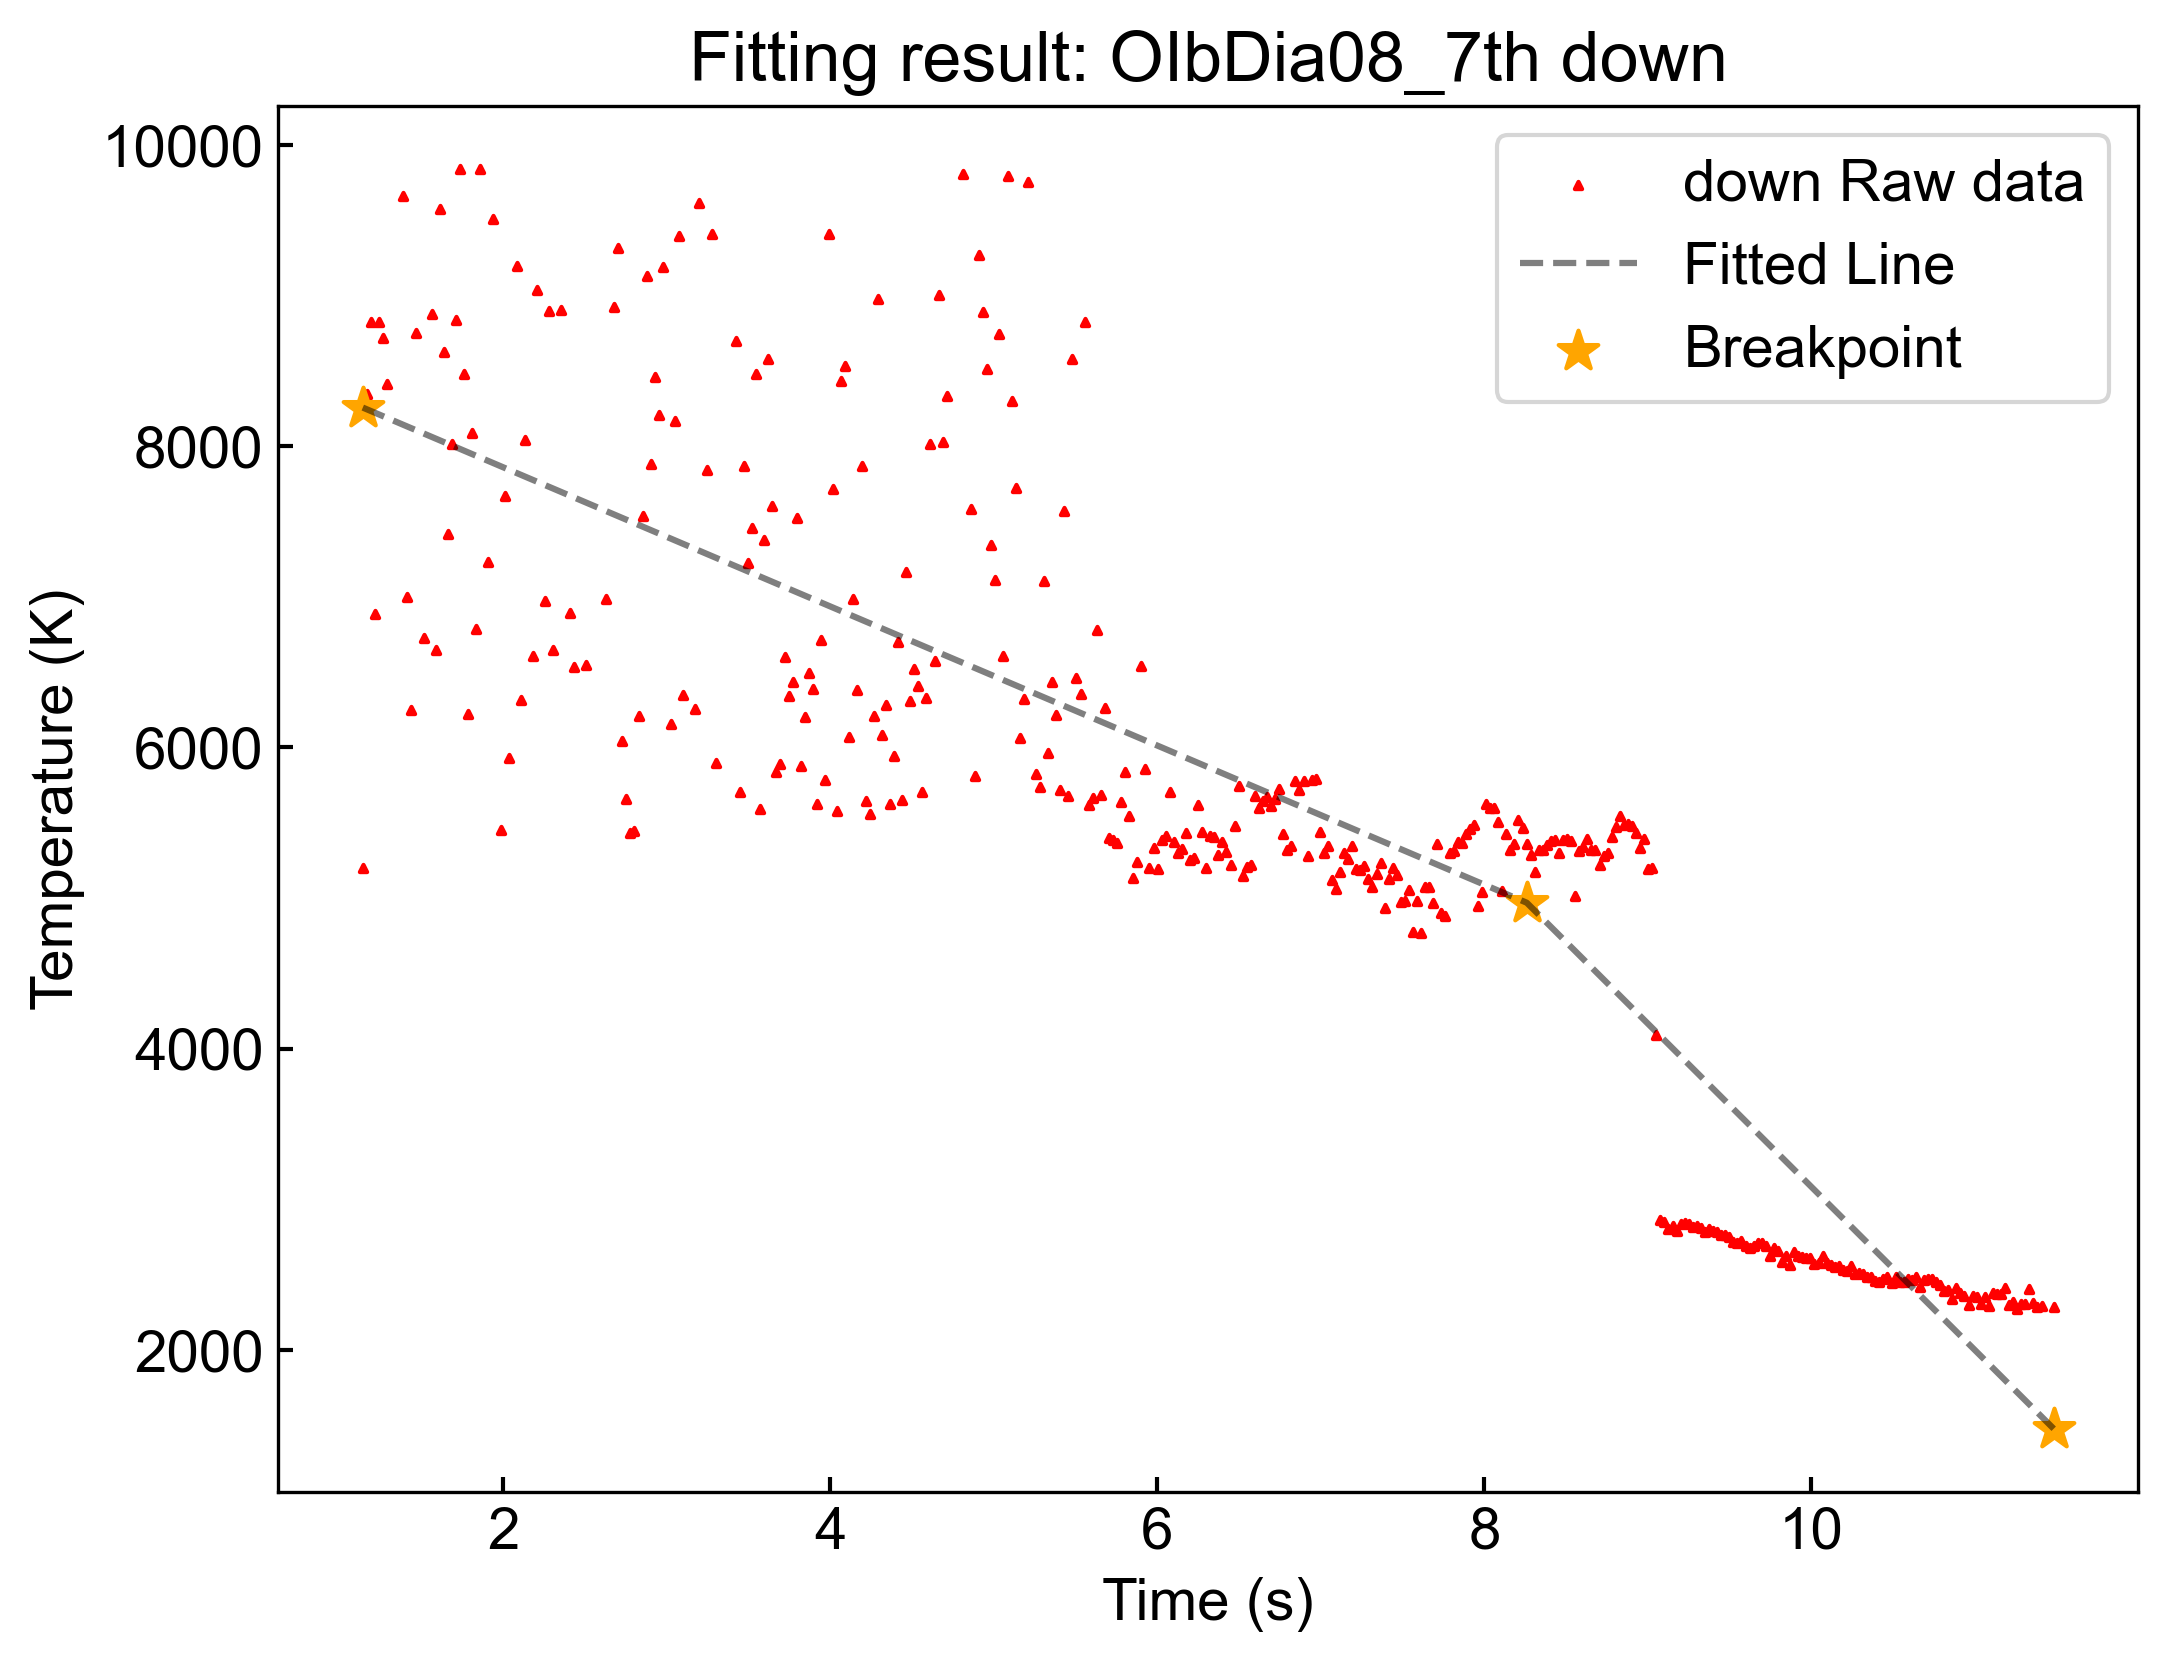

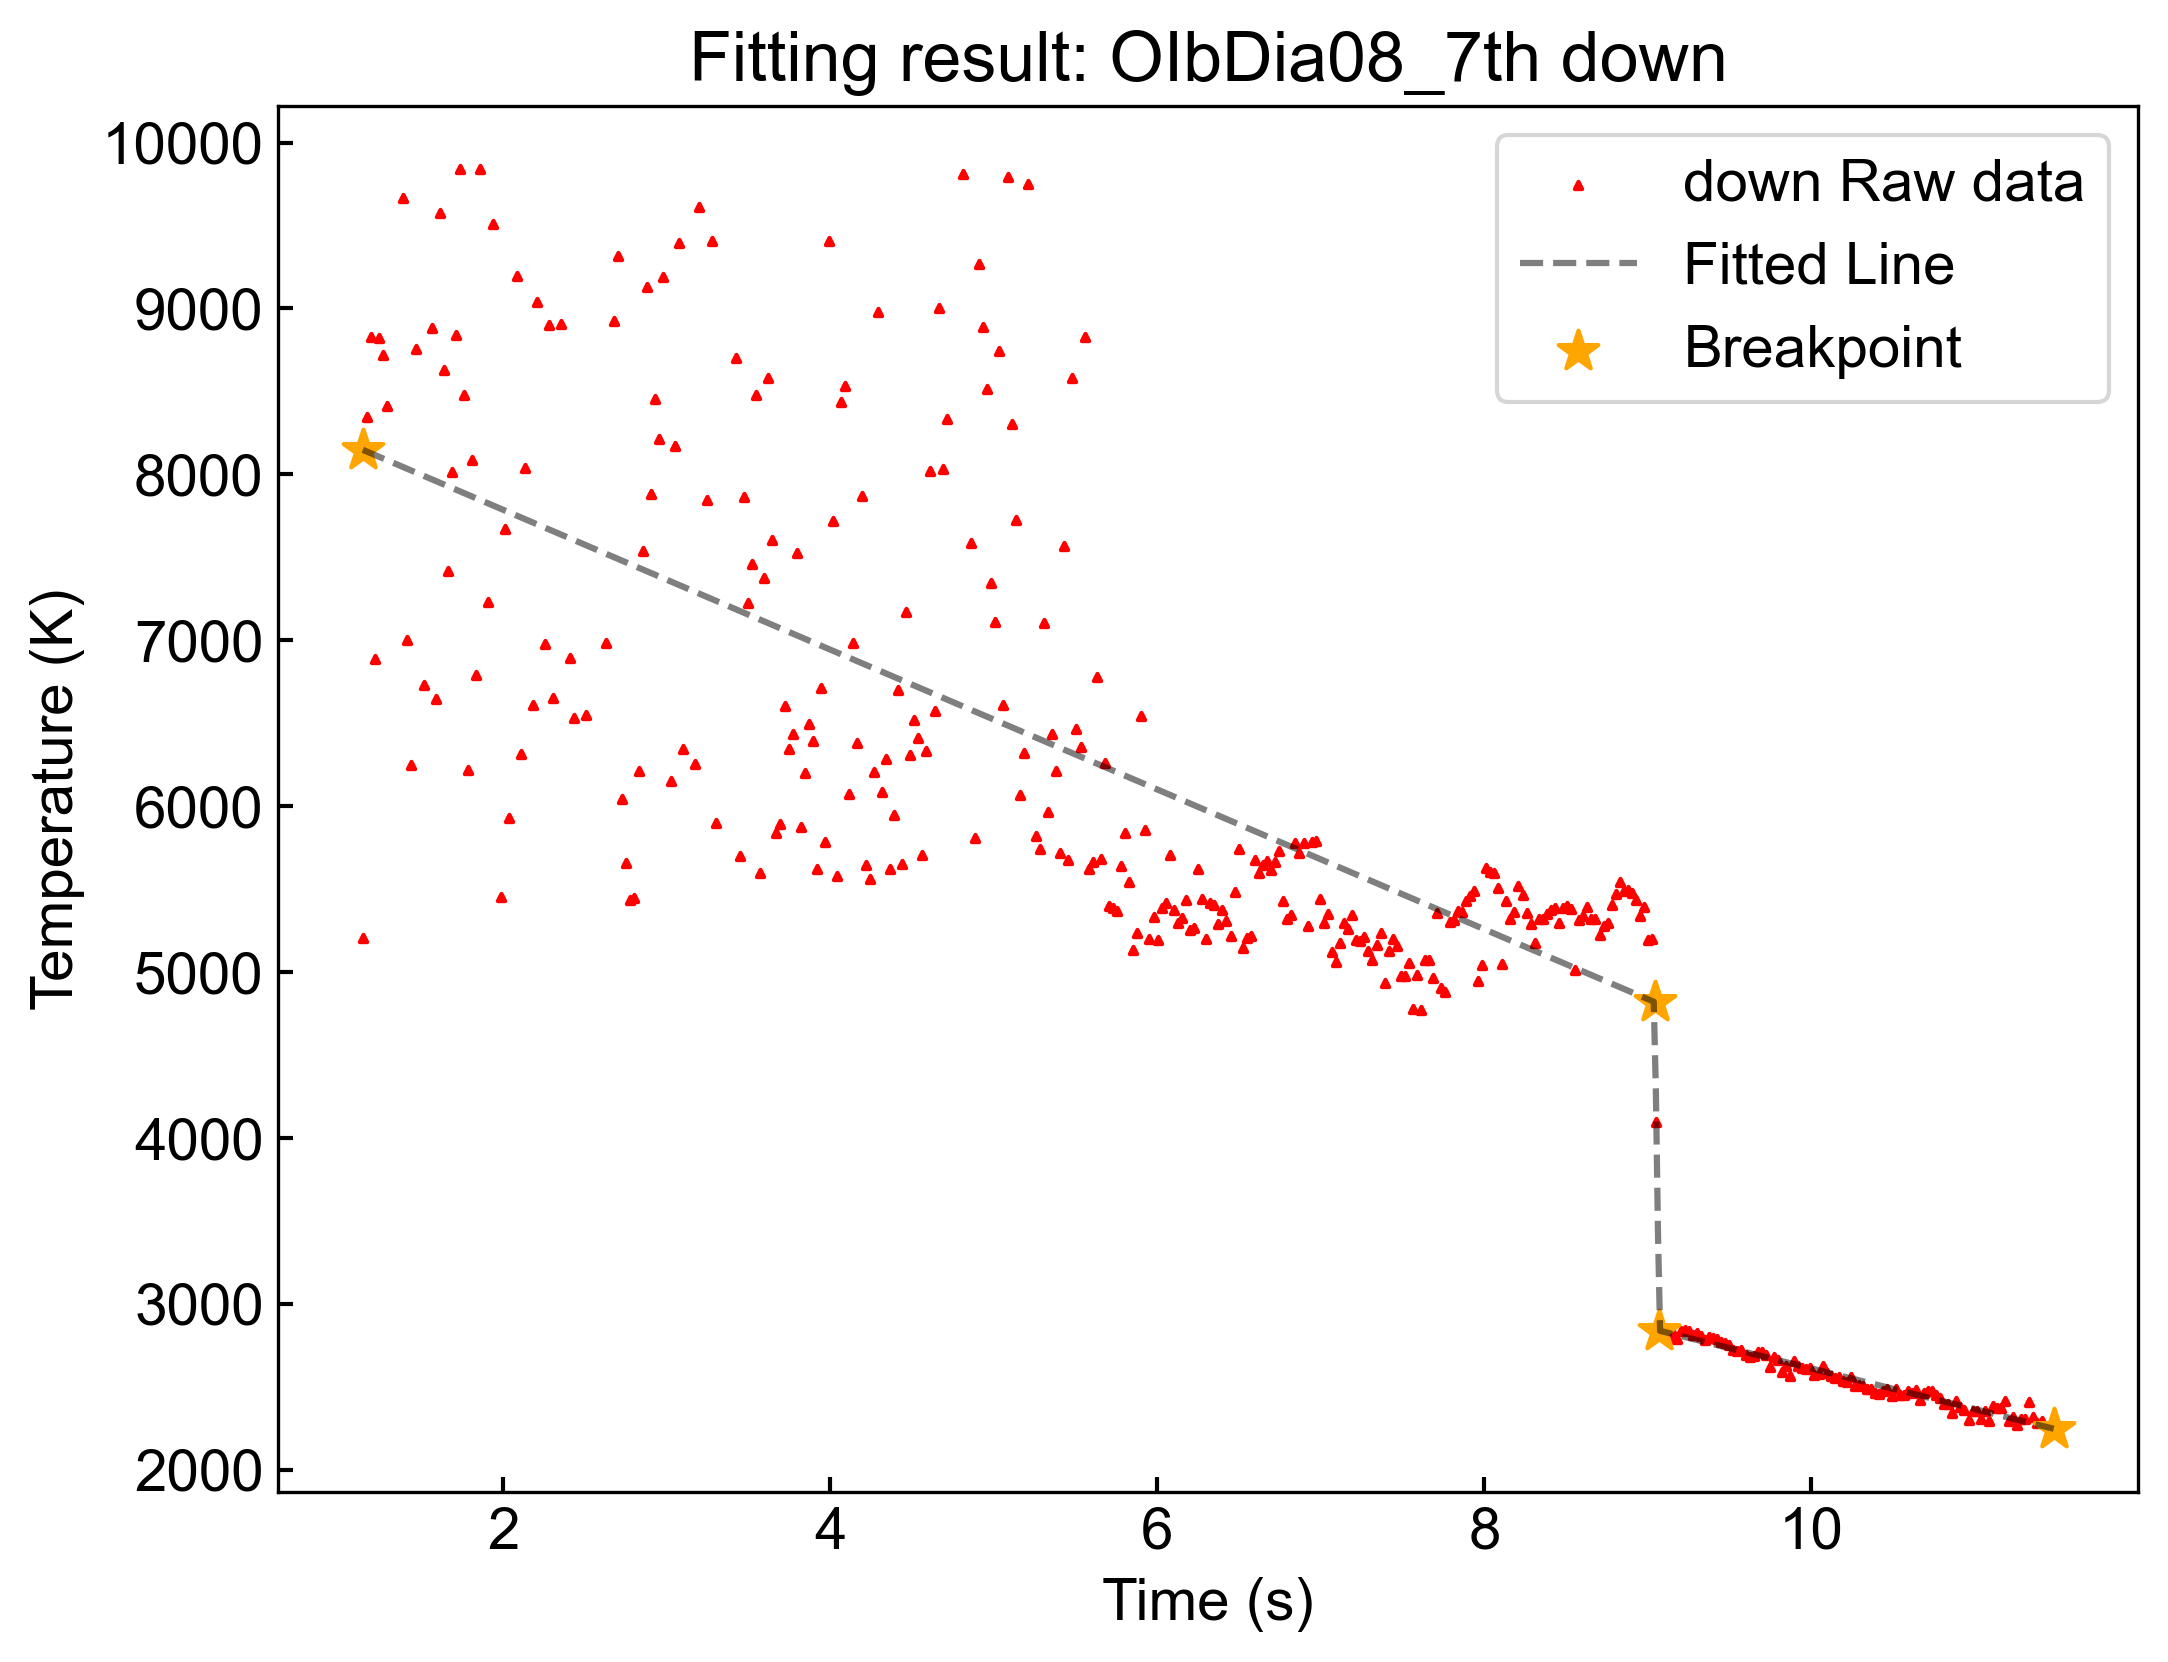

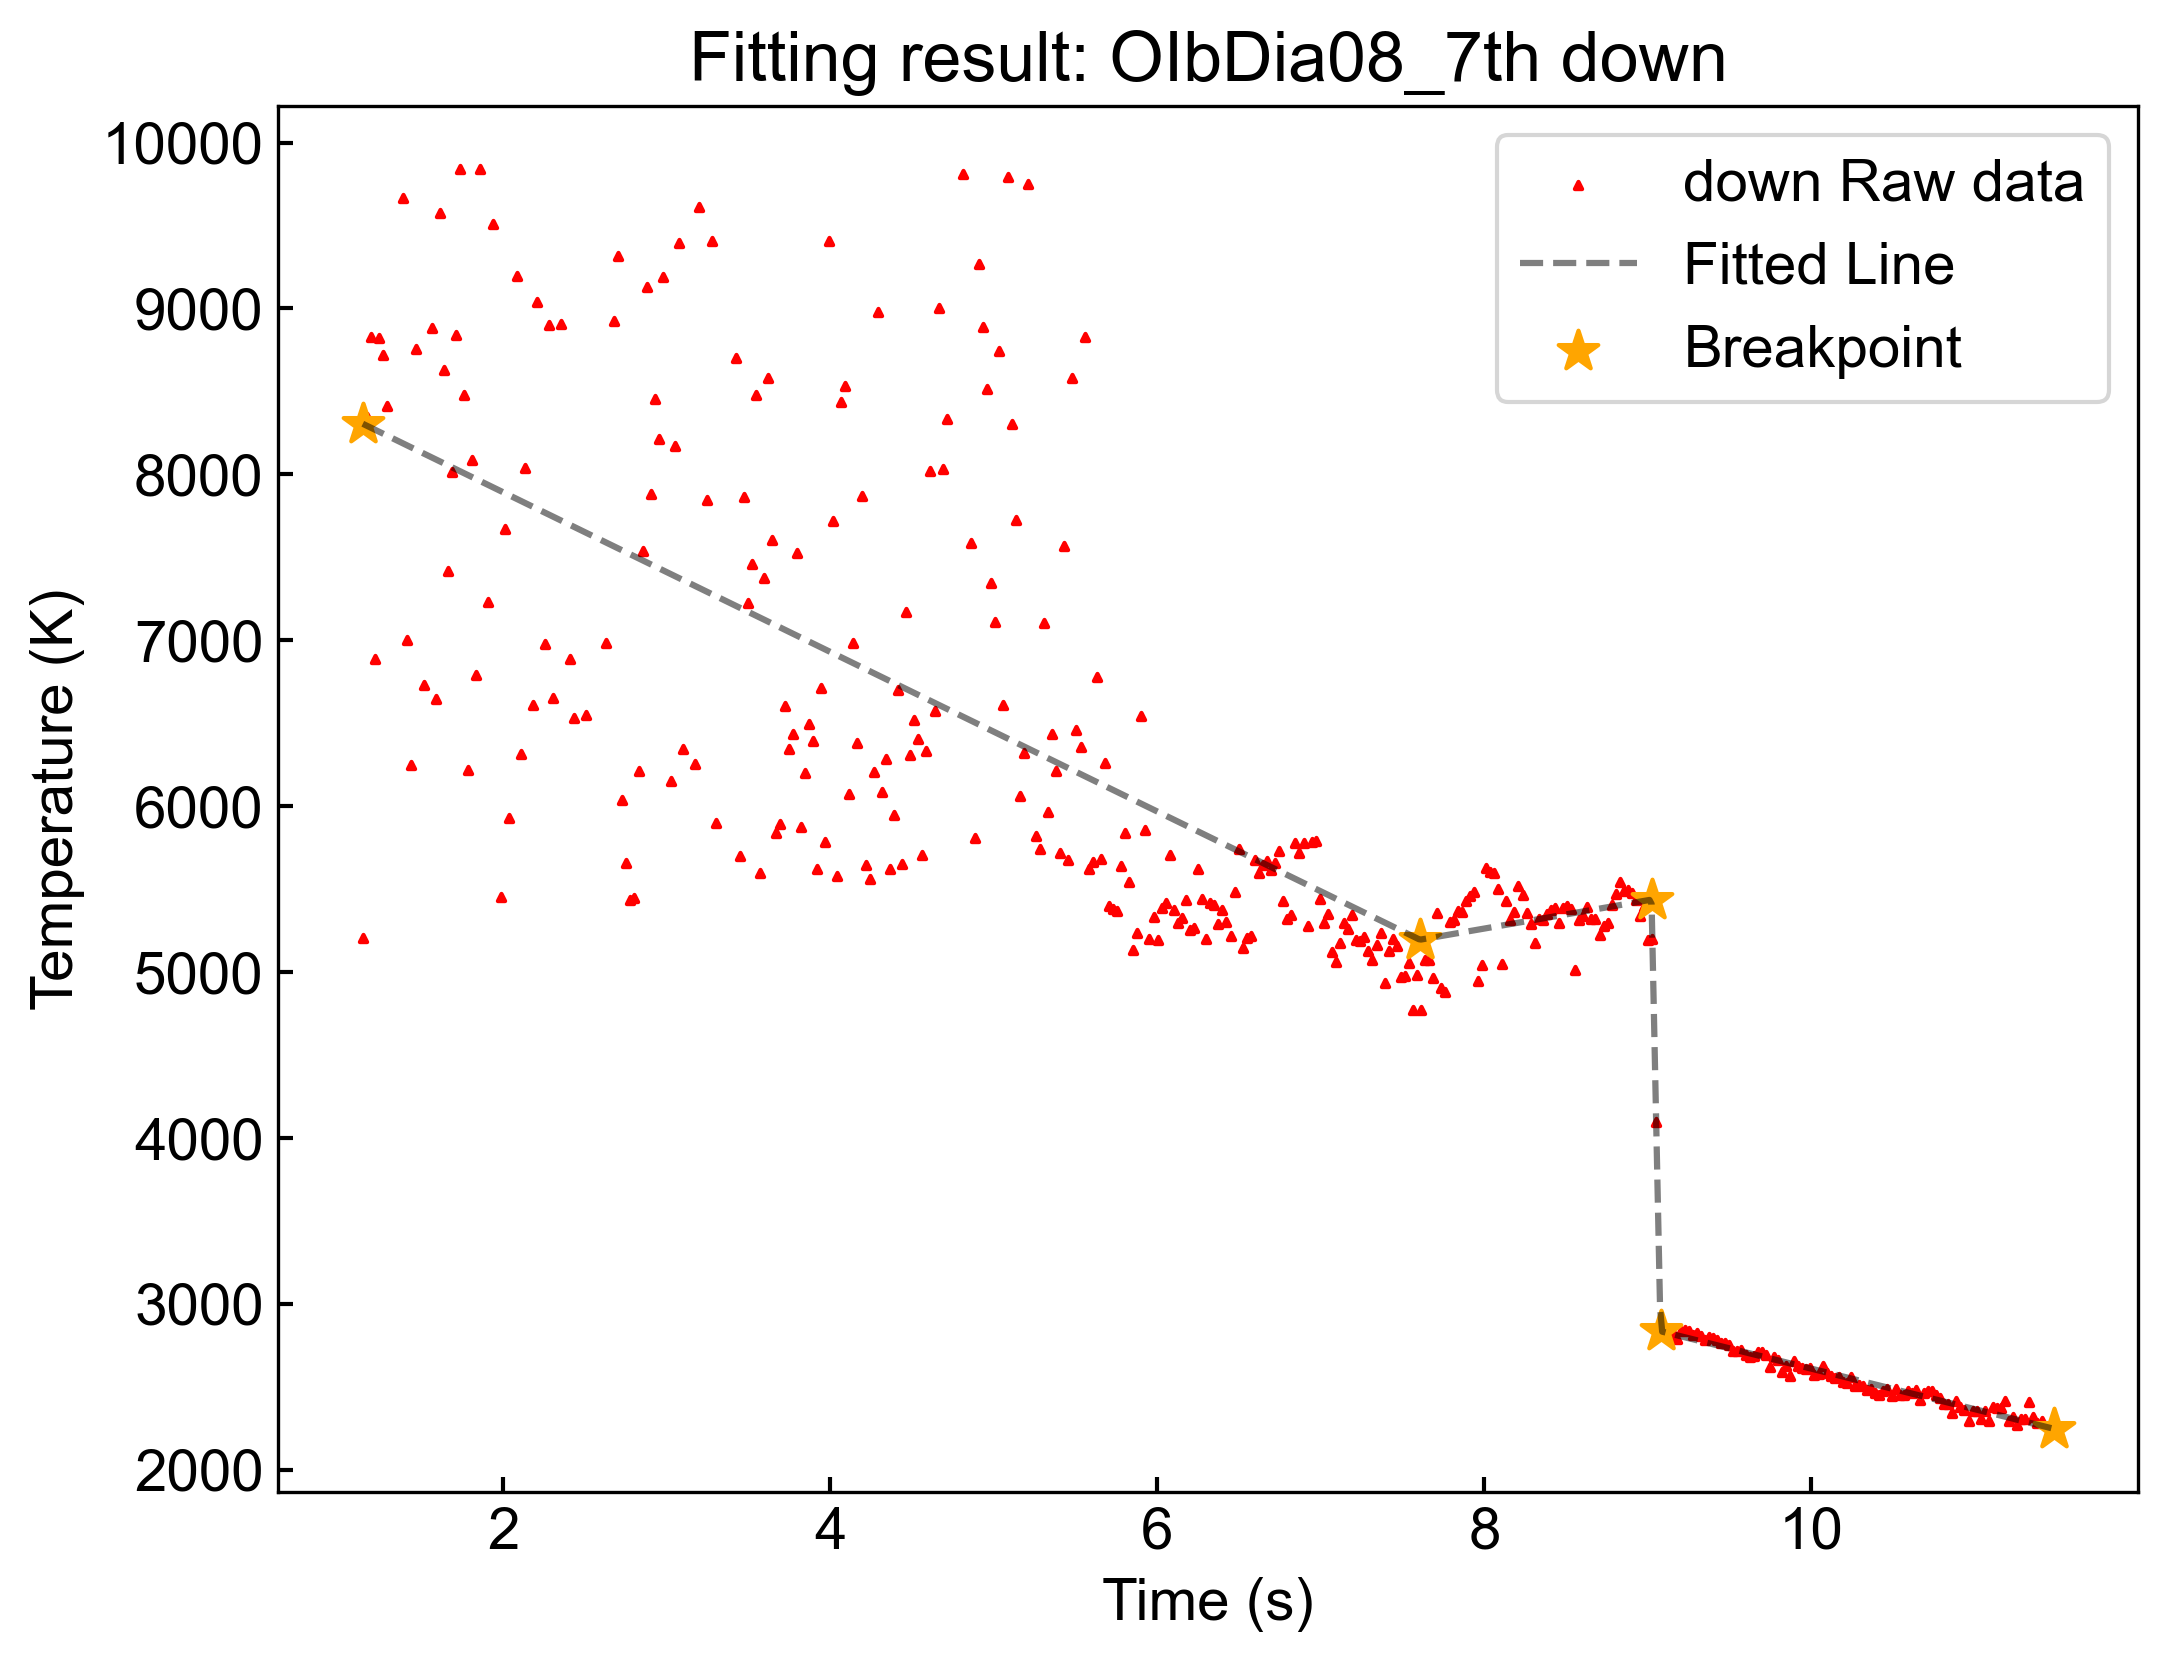

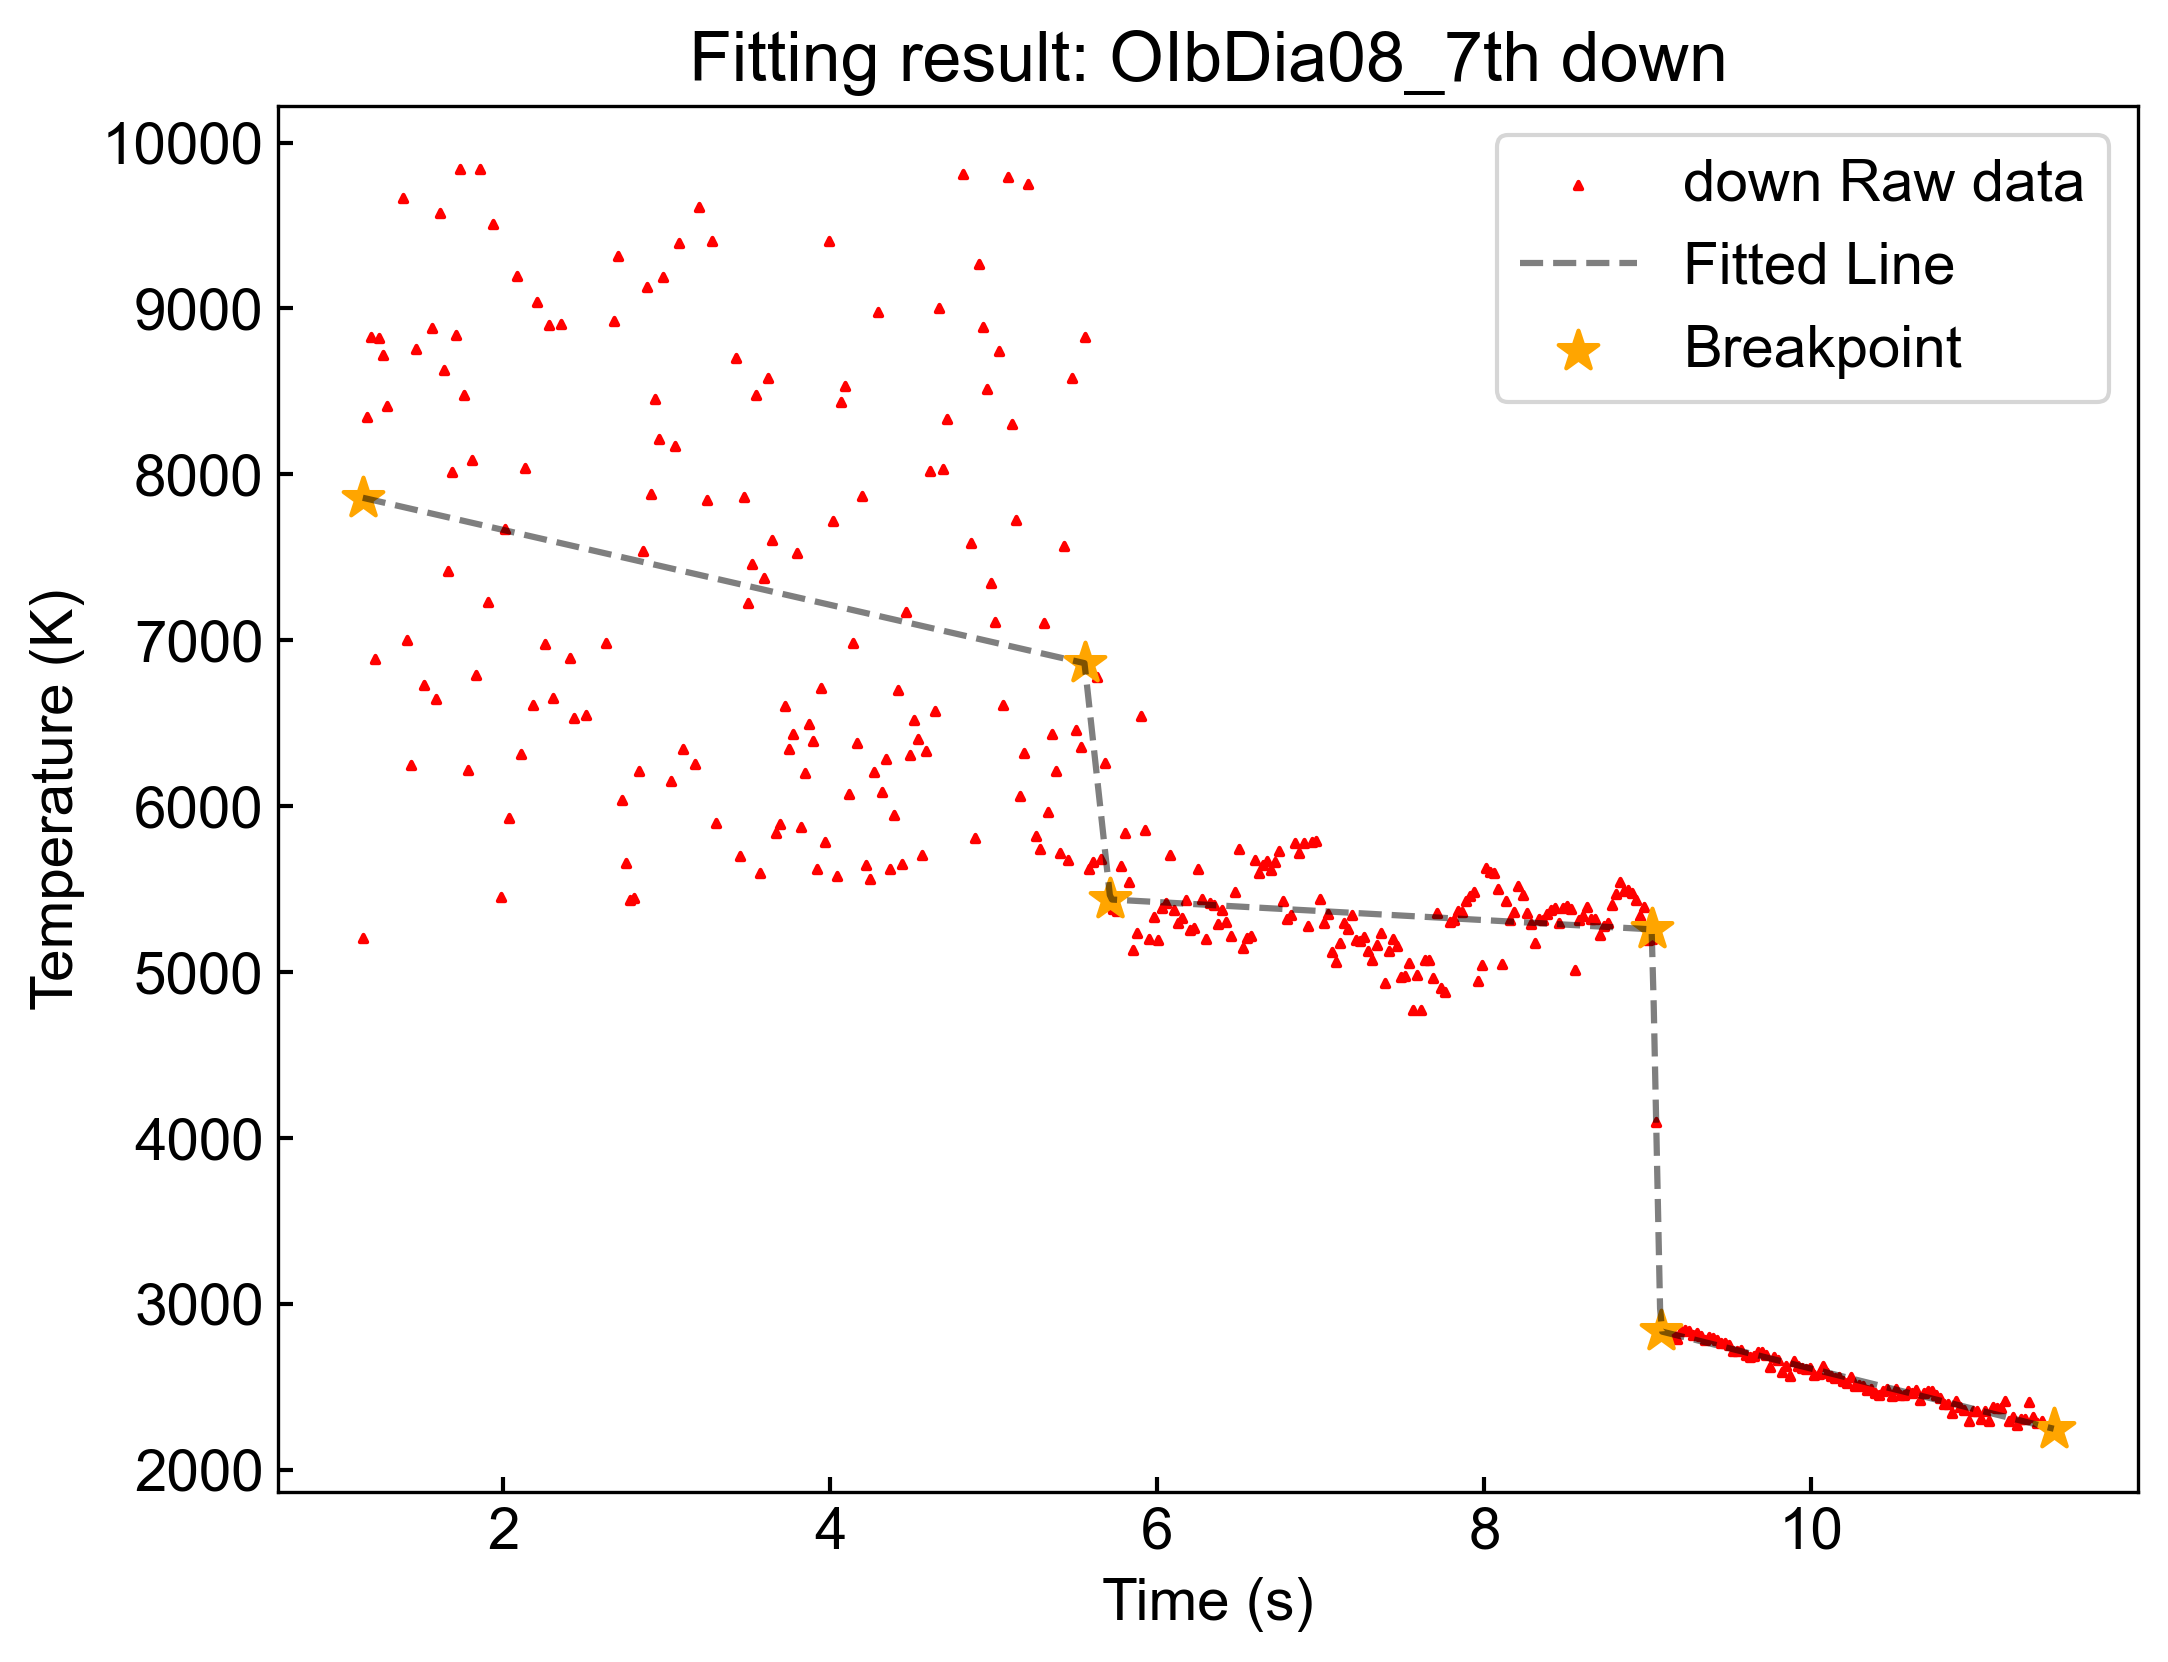

In [125]:
for down_segment_num in segments_num_list:
    res = down_pwlf.fit(down_segment_num)

    # 図示用配列
    down_x_hat_all = np.linspace(down_T_series.index.min(), down_T_series.index.max(), frame_num)
    down_y_hat_all = down_pwlf.predict(down_x_hat_all)

    # 図示
    plt.scatter(down_T_series.index, down_T_series.values, label='down Raw data', s=3, color='red', marker='^')
    plt.plot(down_x_hat_all, down_y_hat_all, color='black', label='Fitted Line', alpha=0.5, linestyle='--')
    plt.scatter(down_pwlf.fit_breaks, down_pwlf.predict(down_pwlf.fit_breaks), label='Breakpoint', s=100, marker='*',
                color='orange')
    plt.xlabel('Time (s)')
    plt.legend()
    plt.xlabel('Time (s)')
    plt.ylabel('Temperature (K)')
    plt.title(f'Fitting result: {selected_run_setting["current_run"]} down')
    plt.savefig(os.path.join(selected_run_setting['save_root_path'], 'fig', 'pwlf_fitting',
                             selected_run_setting['current_run'] + f'_down_{down_segment_num}.png'))
    plt.show()
    plt.close()


# 保存

In [126]:
def add_fitting_result_to_hdf(model, path_to_hdf, segments_num_list):
    """
    Add fitting results from a pwlf.PiecewiseLinFit model to an HDF5 file.

    Parameters:
        model (pwlf.PiecewiseLinFit): The piecewise linear fit model.
        path_to_hdf (str): Path to the HDF5 file where results will be saved.
        segments_num_list (list): List of segment numbers to fit and save results for.
    """
    with h5py.File(path_to_hdf, "a") as hdf:
        # Ensure the 'entry/fitting' group exists
        fitting_group = hdf.require_group("entry/pwlf_fitting")

        for segment_num in segments_num_list:
            # Perform the fit
            model.fit(segment_num)

            # Extract fitting results
            breakpoints_x = model.fit_breaks
            breakpoints_y = model.predict(breakpoints_x)
            slopes = model.slopes
            intercepts = model.intercepts
            RSS = model.r_squared()

            # Create or reuse a group for this segment number
            segment_group = fitting_group.require_group(f"segment_{segment_num}")

            # Save the results, overwriting if they already exist
            for name, data in {
                "breakpoints_x": breakpoints_x,
                "breakpoints_y": breakpoints_y,
                "slopes": slopes,
                "intercepts": intercepts,
                "RSS": RSS
            }.items():
                if name in segment_group:
                    del segment_group[name]
                segment_group.create_dataset(name, data=data)

    print(f"Fitting results saved to {path_to_hdf}")


## Up

In [127]:
# ↑のfittingモデルを保存する
add_fitting_result_to_hdf(
    model=up_pwlf,
    path_to_hdf=os.path.join(
    selected_run_setting['save_root_path'],
    'processed_hdf',
    f'{selected_run_setting["current_run"]}_up_processed.hdf'
    ),
    segments_num_list=segments_num_list
)

Fitting results saved to /Users/ishizawaosamu/work/MasterThesis/save/processed_hdf/OIbDia08_7th_up_processed.hdf


## Down

In [128]:
add_fitting_result_to_hdf(
    model=down_pwlf,
    path_to_hdf=os.path.join(
        selected_run_setting['save_root_path'],
        'processed_hdf',
        f'{selected_run_setting["current_run"]}_down_processed.hdf'
    ),
    segments_num_list=segments_num_list
)


Fitting results saved to /Users/ishizawaosamu/work/MasterThesis/save/processed_hdf/OIbDia08_7th_down_processed.hdf


# 確認

In [129]:
# up
up_hdf = HDF5Reader(file_path=os.path.join(
    selected_run_setting['save_root_path'],
    'processed_hdf',
    f'{selected_run_setting["current_run"]}_up_processed.hdf'
))

# down
down_hdf = HDF5Reader(file_path=os.path.join(
    selected_run_setting['save_root_path'],
    'processed_hdf',
    f'{selected_run_setting["current_run"]}_down_processed.hdf'
))

up_hdf.path_list


HDF5ファイルが見つかりました: /Users/ishizawaosamu/work/MasterThesis/save/processed_hdf/OIbDia08_7th_up_processed.hdf
HDF5ファイルが見つかりました: /Users/ishizawaosamu/work/MasterThesis/save/processed_hdf/OIbDia08_7th_down_processed.hdf


['entry/measured/error/T',
 'entry/measured/value/T',
 'entry/measured/value/frame_T',
 'entry/measured/value/max_position_T',
 'entry/params/frame/T',
 'entry/params/framerate/T',
 'entry/pwlf_fitting/segment_2/RSS',
 'entry/pwlf_fitting/segment_2/breakpoints_x',
 'entry/pwlf_fitting/segment_2/breakpoints_y',
 'entry/pwlf_fitting/segment_2/intercepts',
 'entry/pwlf_fitting/segment_2/slopes',
 'entry/pwlf_fitting/segment_3/RSS',
 'entry/pwlf_fitting/segment_3/breakpoints_x',
 'entry/pwlf_fitting/segment_3/breakpoints_y',
 'entry/pwlf_fitting/segment_3/intercepts',
 'entry/pwlf_fitting/segment_3/slopes',
 'entry/pwlf_fitting/segment_4/RSS',
 'entry/pwlf_fitting/segment_4/breakpoints_x',
 'entry/pwlf_fitting/segment_4/breakpoints_y',
 'entry/pwlf_fitting/segment_4/intercepts',
 'entry/pwlf_fitting/segment_4/slopes',
 'entry/pwlf_fitting/segment_5/RSS',
 'entry/pwlf_fitting/segment_5/breakpoints_x',
 'entry/pwlf_fitting/segment_5/breakpoints_y',
 'entry/pwlf_fitting/segment_5/intercepts',

In [130]:
def plot_fitting_results_with_reader(reader, segment_num):
    """
    Plot the raw data and breakpoints for a given segment number using HDF5Reader.

    Parameters:
        reader (HDF5Reader): The HDF5Reader instance to fetch data from.
        segment_num (int): The segment number to plot.
    """
    # Query paths
    raw_x_query = 'entry/measured/value/frame_T'
    raw_y_query = 'entry/measured/value/T'
    breakpoints_x_query = f'entry/pwlf_fitting/segment_{segment_num}/breakpoints_x'
    breakpoints_y_query = f'entry/pwlf_fitting/segment_{segment_num}/breakpoints_y'

    # Retrieve data using the reader
    framerate = reader.find_by(query='framerate')
    raw_x = reader.find_by(query=raw_x_query) / framerate
    raw_y = reader.find_by(query=raw_y_query)
    breakpoints_x = reader.find_by(query=breakpoints_x_query)
    breakpoints_y = reader.find_by(query=breakpoints_y_query)

    # Plot raw data
    plt.figure(figsize=(10, 6))
    plt.plot(raw_x, raw_y, label="Raw Data", linestyle="-", marker=".")

    # Plot breakpoints
    plt.plot(breakpoints_x, breakpoints_y, label=f"Segment {segment_num} Breakpoints", linestyle="--", marker="o", color="red")

    # Add labels and legend
    plt.xlabel("Frame (T)")
    plt.ylabel("Measured Value (T)")
    plt.title(f"Raw Data and Fitting Breakpoints (Segment {segment_num})")
    plt.legend()
    plt.grid()
    plt.show()


「framerate」で検索します。
	-> entry/params/framerate/T を返しました。
「entry/measured/value/frame_T」で検索します。
	-> entry/measured/value/frame_T を返しました。
「entry/measured/value/T」で検索します。
	-> entry/measured/value/T を返しました。
「entry/pwlf_fitting/segment_4/breakpoints_x」で検索します。
	-> entry/pwlf_fitting/segment_4/breakpoints_x を返しました。
「entry/pwlf_fitting/segment_4/breakpoints_y」で検索します。
	-> entry/pwlf_fitting/segment_4/breakpoints_y を返しました。


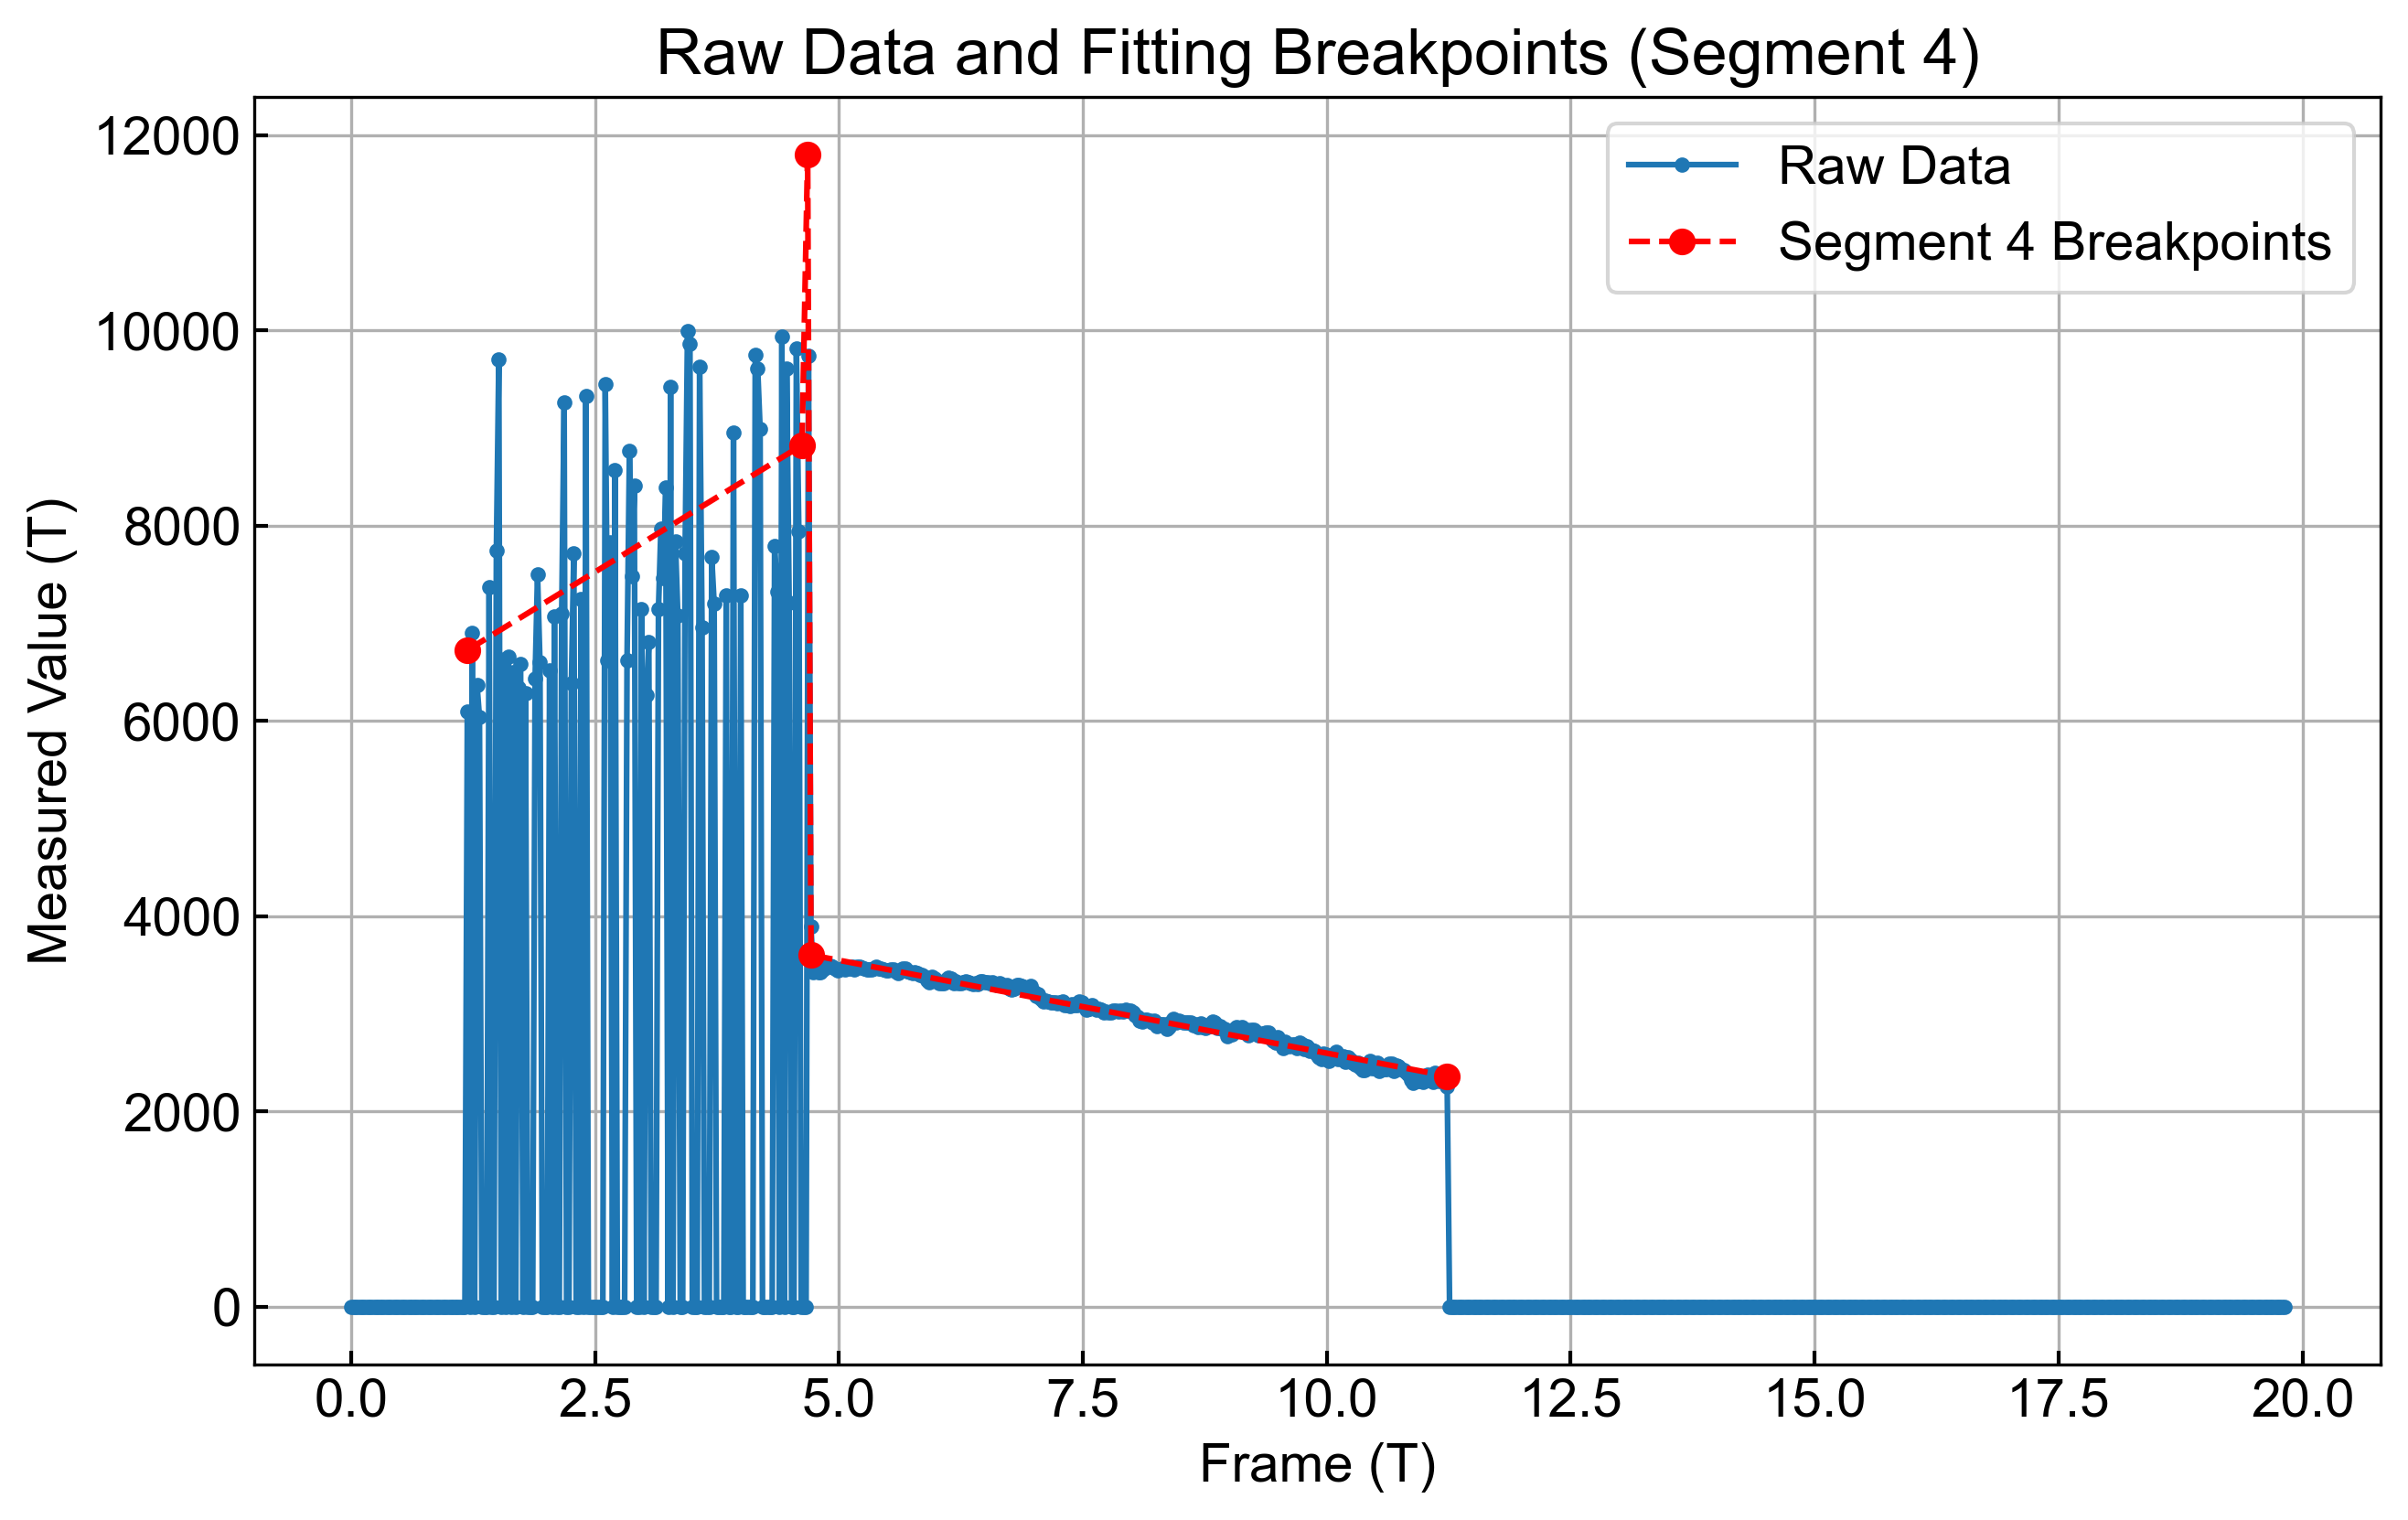

In [131]:
plot_fitting_results_with_reader(up_hdf, 4)

「framerate」で検索します。
	-> entry/params/framerate/T を返しました。
「entry/measured/value/frame_T」で検索します。
	-> entry/measured/value/frame_T を返しました。
「entry/measured/value/T」で検索します。
	-> entry/measured/value/T を返しました。
「entry/pwlf_fitting/segment_4/breakpoints_x」で検索します。
	-> entry/pwlf_fitting/segment_4/breakpoints_x を返しました。
「entry/pwlf_fitting/segment_4/breakpoints_y」で検索します。
	-> entry/pwlf_fitting/segment_4/breakpoints_y を返しました。


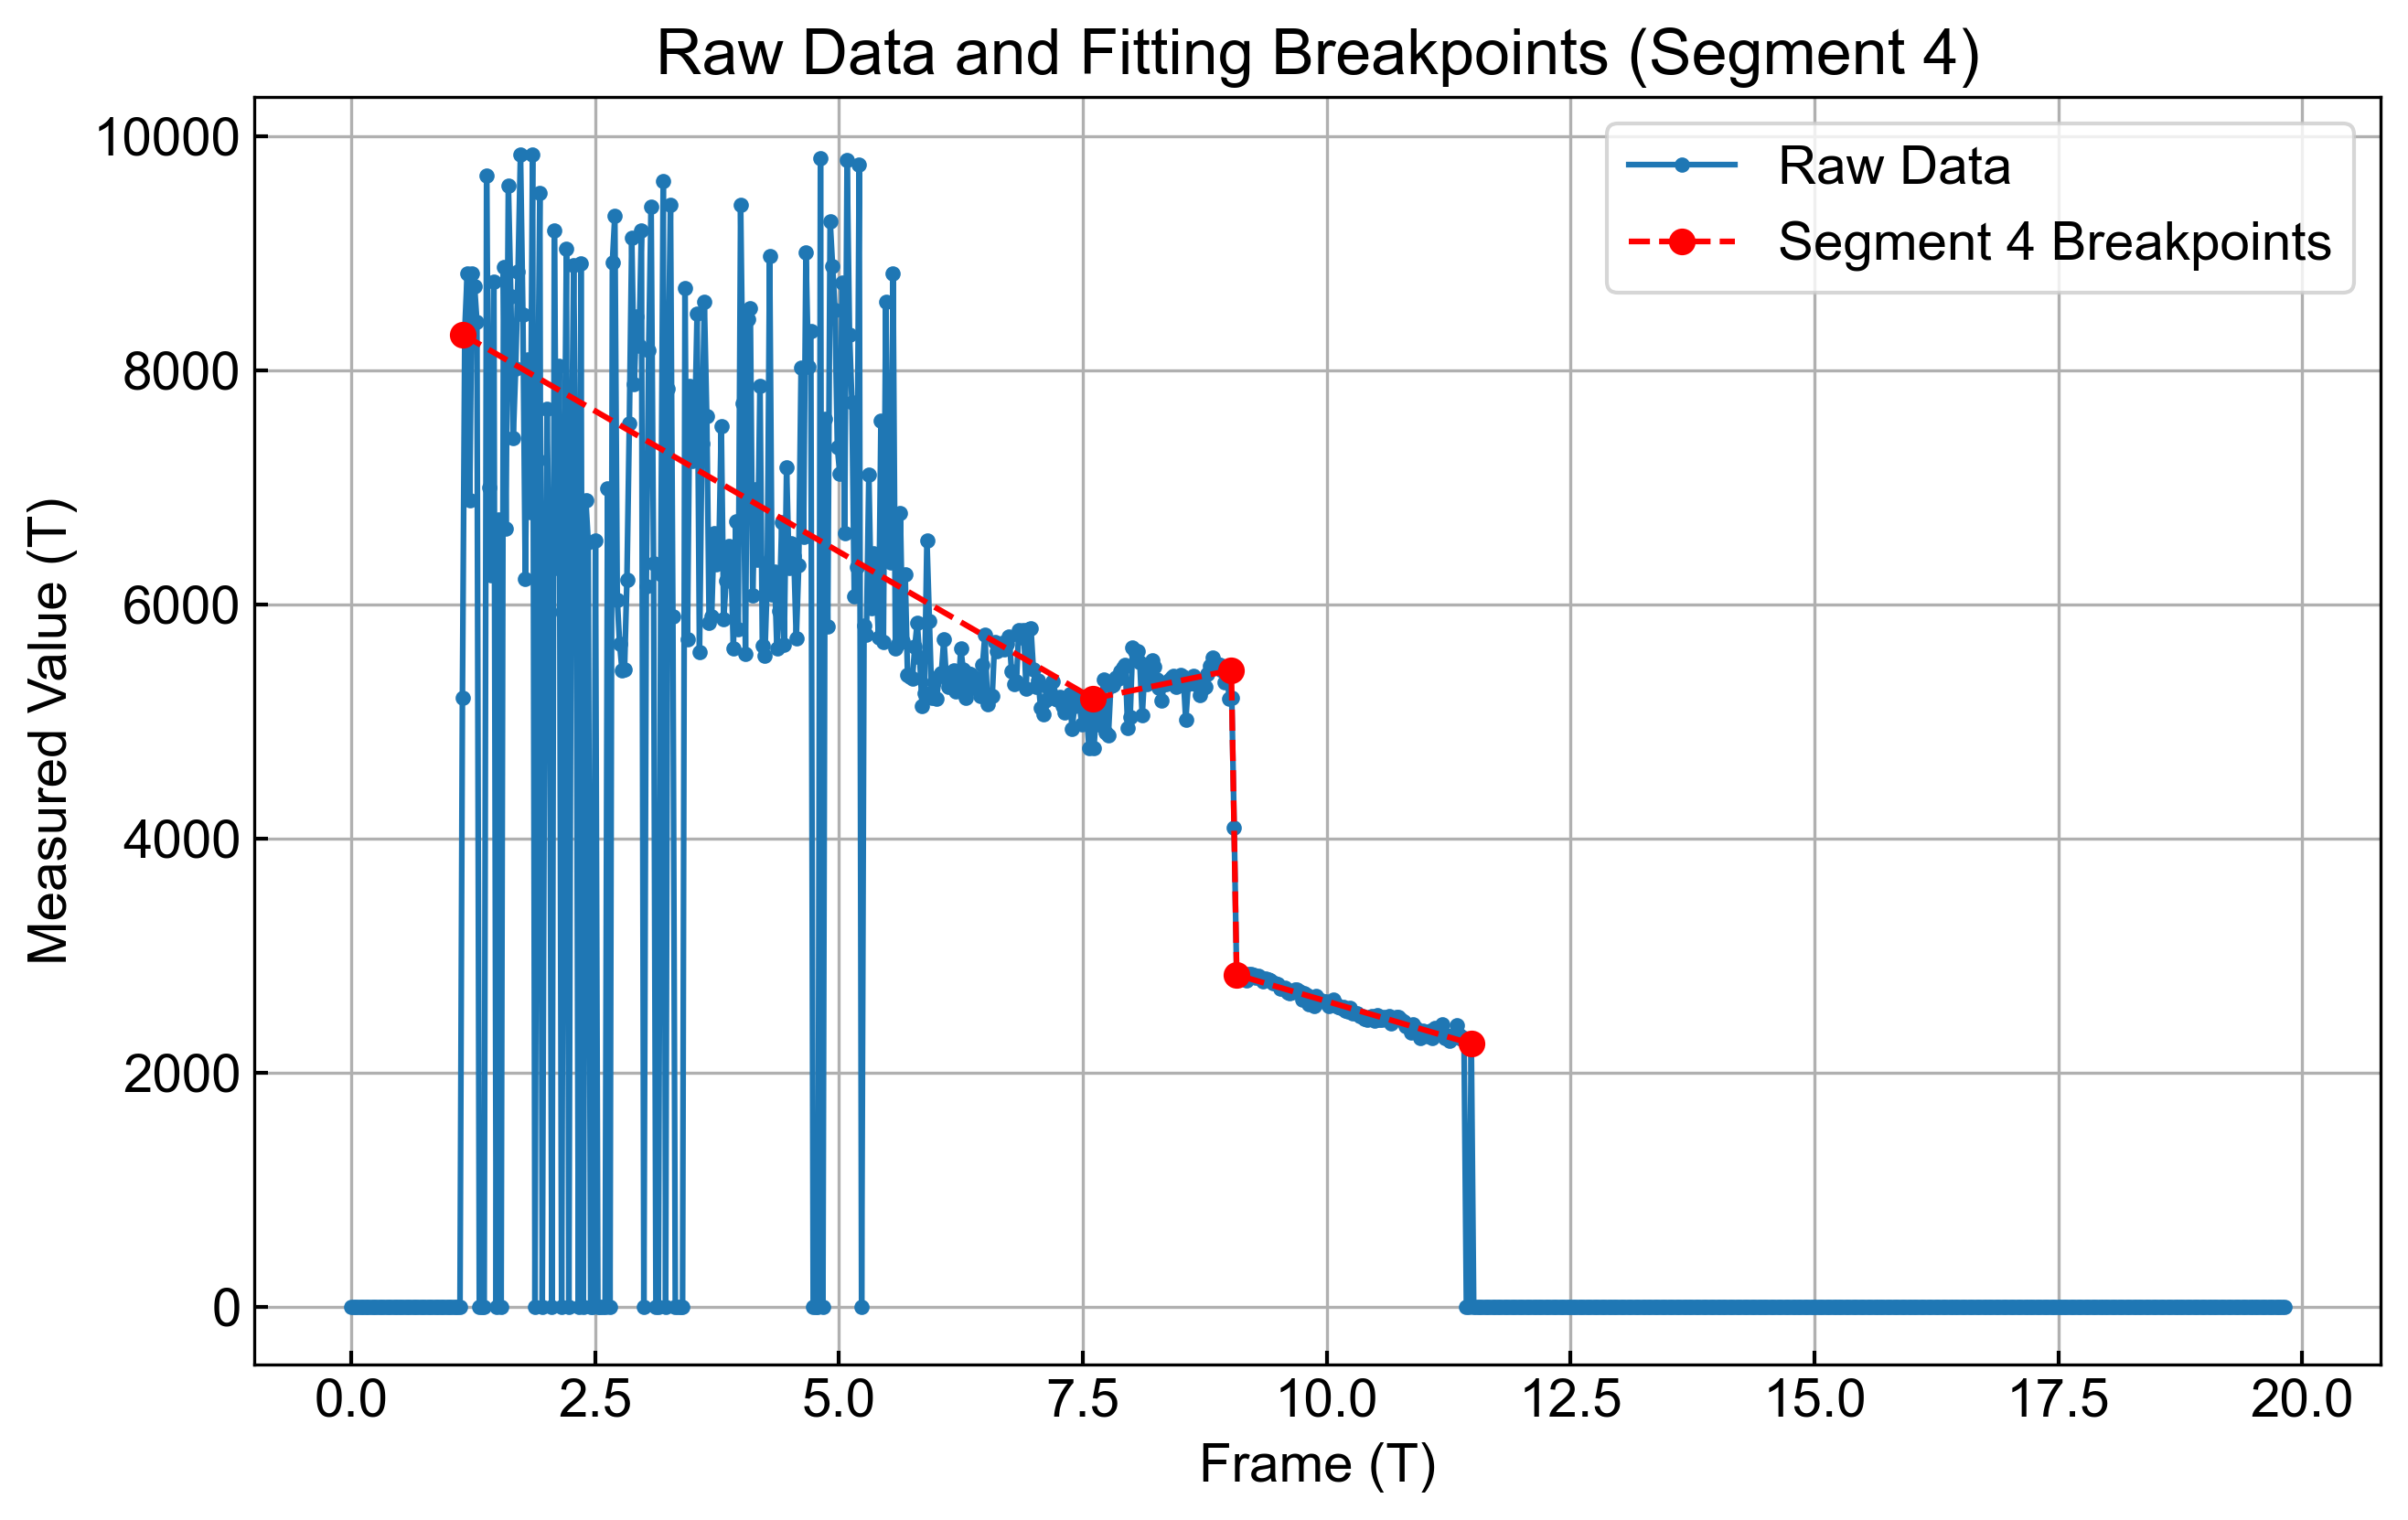

In [132]:
plot_fitting_results_with_reader(down_hdf, 4)
